# LIBRERIE + PIP

In [ ]:
!pip install unidecode simplejson nltk wordcloud

In [ ]:
pip install umap-learn

In [ ]:
pip install sentence-transformers

In [ ]:
pip install langdetect

In [ ]:
pip install googletrans==4.0.0-rc1

In [ ]:
!pip install bertopic

In [ ]:
!pip install bertopic[flair,gensim,spacy,use]
!pip install bertopic[vision]

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline
import pandas as pd
import re
from nltk.corpus import stopwords
from unidecode import unidecode
from collections import Counter
from wordcloud import WordCloud
import nltk
from IPython.display import Image
import matplotlib.pyplot as plt
from googletrans import Translator
from langdetect import detect
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from nltk.stem import PorterStemmer
from sklearn.metrics.pairwise import euclidean_distances
import requests
from nltk.tokenize import sent_tokenize, word_tokenize
from umap import UMAP
from bertopic import BERTopic
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
import numpy as np
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist, squareform
import scipy.sparse
from sklearn.cluster import DBSCAN
from sentence_transformers import SentenceTransformer
from matplotlib.lines import Line2D
from PIL import Image
import altair as alt

%matplotlib inline

nltk.download("stopwords")

C:\Users\simon\anaconda3\envs\env_master\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\simon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# INTRO, LOWERCASE, ELIMINAZ "NAN", ECC...

In [ ]:
alt.data_transformers.enable('default', max_rows=None)

DataTransformerRegistry.enable('default')

In [ ]:
# df=pd.read_csv(r"C:\Users\simon\Desktop\excel progetto uni\dfcompletomistral.csv", encoding='utf-8') # DF totale da pulire

df=pd.read_csv(r'C:\Users\simon\Desktop\df_Pulito_Tot.csv') # DF pultio senza outliers, quindi runna solo alcune celle

In [ ]:
len(df)

6606

In [ ]:
df.columns

Index(['Unnamed: 0.2', 'Unnamed: 0', 'keySearch', 'workplaceSearch',
       'nameUser', 'jobPostId', 'page_List_Position', 'applicationsCount',
       'companyId', 'companyName', 'companyUrl', 'locationType',
       'contractType', 'skillsList', 'qualificationList', 'description',
       'descriptionComplete', 'descriptionComplete2', 'experienceLevel',
       'jobUrl', 'location', 'republished', 'postedTime', 'posterFullName',
       'posterProfileUrl', 'publishedAt', 'salary', 'companySize', 'sector',
       'title', 'workType', 'scrapedTime', 'title_eng', 'title_sum',
       'description_eng', 'data', 'ora', 'TM2', 'index', 'cluster',
       'Anomaly Score', 'input', 'role_description', 'Unnamed: 0.1',
       'conta_freq', 'token_job_description', 'token_job_description_filtered',
       'token_job_description_normalized', 'token_job_description_stemmed',
       'T/F', 'sentence_transformers_labels', 'collocations', 'label',
       'label2', 'softskills'],
      dtype='object')

In [ ]:
# elimino le righe dove la cella della traduzione è "nan"
df.drop(df[df['description_eng'].isna()].index, axis=0, inplace=True)

# elimino le righe dove il titolo è "nan"
df.drop(df[df['title_eng'].isna()].index, axis=0, inplace=True)
df.drop(df[df['title_sum'].isna()].index, axis=0, inplace=True)

In [ ]:
len(df)

6606

In [ ]:
df = df.reset_index(drop=True)

### METTIAMO IN MINUSCOLO LA JOB DESCRIPTION, TITOLI E ROLE DESCRIPTION

In [ ]:
def lower(cella):
    if isinstance(cella, str):
        return cella.lower()
    else:
        return str(cella).lower()

df['description_eng']=df['description_eng'].apply(lower)
df['title_eng']=df['title_eng'].apply(lower)
df['role_description']=df['role_description'].apply(lower)

### UNIAMO CON "_" COPPIE DI PAROLE CHE NON VANNO DIVISE QUANDO SI TOKENIZZA

In [ ]:
special_token = ["machine learning", "data analyst", 'computer vision', 'big data',
                 'deep learning', 'software engineering', 'computer science',
                 'business intelligence', 'artificial intelligence', 'data scientist', "data science",
                 'natural language processing', 'neural network', 'cloud computing', 'cyber security'
                 'internet of things', 'augmented reality', 'virtual reality','quantum computing','data mining',
                 'data visualization', 'information retrieval', 'predictive analytics', 'reinforcement learning',
                 'digital transformation', 'edge computing', 'knowledge graph', 'user experience', 'human computer interaction',
                 'software development', 'data base', 'relational database']

def special_words(cella):
    for a in special_token:
        cella = cella.replace(a, a.replace(" ", "_"))
    return cella

df['description_eng']=df['description_eng'].apply(special_words)

# non lo faccio su 'role description' in quanto li sono presenti prevalentemente le skills. Lo facciamo sulla descrizione in qunato mi darà una panoramica più generale nella word cloud

### NUOVA COLONNA: TITOLI SIMILI VENGONO MESSI SOTTO UN UNICO NOME

In [ ]:
# Crea una nuova colonna 'title_sum' con valori vuoti
df['title_sum'] = ''

# Se 'title' contiene 'sviluppatore', allora in 'title_sum' viene scritto 'sviluppatore'
#df.loc[df['title_eng'].str.contains(r'\b(backend|java engineer|python engineer|developer|devops)\b', case=False, na=False), 'title_sum'] = 'developer'

df.loc[df['title_eng'].str.contains(r'\b(front|front-end|frontend|front end)\b', case=False, na=False), 'title_sum'] = 'front-end developer'
df.loc[df['title_eng'].str.contains(r'\b(back|back-end|back end|backend)\b', case=False, na=False), 'title_sum'] = 'back-end developer'
df.loc[df['title_eng'].str.contains(r'\b(full-stak|stack|full stack|fullstack)\b', case=False, na=False), 'title_sum'] = 'full-stak developer'
df.loc[df['title_eng'].str.contains(r'\b(mobile|mobile developer|mobile-developer)\b', case=False, na=False), 'title_sum'] = 'mobile developer'
df.loc[df['title_eng'].str.contains(r'\b(devops|operations developer|developer)\b', case=False, na=False), 'title_sum'] = 'DevOps engineer'
df.loc[df['title_eng'].str.contains(r'\b(embedded|embedding|system)\b', case=False, na=False), 'title_sum'] = 'system/embedding engineer'
df.loc[df['title_eng'].str.contains(r'\b(python developer|python|java|senior java developer|java developer)\b', case=False, na=False), 'title_sum'] = 'python/java developer'
df.loc[df['title_eng'].str.contains(r'\b(business analytic|business analytics)\b', case=False, na=False), 'title_sum'] = 'business analytics'
df.loc[df['title_eng'].str.contains(r'\b(architect)\b', case=False, na=False), 'title_sum'] = 'data architect'

# Se 'title' contiene 'data analyst' o 'analista dati', allora in 'title_sum' viene scritto 'Data analyst'
df.loc[df['title_eng'].str.contains(r'\b(data analyst|analyst|data & analytics|analyst data|data analytics|quant|quantitative|analista|analista dati)\b',
                                    case=False, na=False, flags=re.IGNORECASE), 'title_sum'] = 'data analyst'

# Se 'title' contiene 'data scientist', allora in 'title_sum' viene scritto 'Data scientist'
df.loc[df['title_eng'].str.contains(r'\b(data scientist|data science)\b', case=False, na=False, flags=re.IGNORECASE), 'title_sum'] = 'data scientist'

# Se 'title' contiene 'software engineer', allora in 'title_sum' viene scritto 'software engineer'
df.loc[df['title_eng'].str.contains(r'\b(system|system engineer)\b', case=False, na=False, flags=re.IGNORECASE), 'title_sum'] = 'system engineer'

# Se 'title' contiene 'software engineer', allora in 'title_sum' viene scritto 'software engineer'
df.loc[df['title_eng'].str.contains(r'\b(software|sviluppatore|software engineer|software engineering)\b', case=False, na=False, flags=re.IGNORECASE), 'title_sum'] = 'software engineer'

# Se 'title' contiene 'data engineer', allora in 'title_sum' viene scritto 'Data engineer'
df.loc[df['title_eng'].str.contains(r'\b(data engineer|ingegnere dei dati|data engineering)\b', case=False, na=False, flags=re.IGNORECASE), 'title_sum'] = 'data engineer'

# Se 'title' contiene 'AI engineer', 'Artificial intelligence engineer', 'Artificial intelligence', 'Intelligenza artificiale', 'IA', 'Ingegnere intelligenza artificiale', allora in 'title_sum' viene scritto 'AI engineer'
df.loc[df['title_eng'].str.contains(r'\b(ai engineer|artificial intelligence engineer|artificial intelligence|ai|machine learning engineer|deep learning|ml engineer|ml engineering|machine learning)\b',
                                    case=False, na=False, flags=re.IGNORECASE), 'title_sum'] = 'AI engineer'

# Se 'title' contiene 'BI' allora in 'title_sum' viene scritto BI
df.loc[df['title_eng'].str.contains(r'\b(bi|business intelligence|business analyst|warehouse|sql|mysql|dba|database|data base|db)\b',
                                    case=False, na=False, flags=re.IGNORECASE), 'title_sum'] = 'BI'

# Se 'title' contiene 'Cloud' allora in 'title_sum' viene scritto Cloud
df.loc[df['title_eng'].str.contains(r'\b(cloud|azure)\b', case=False, na=False, flags=re.IGNORECASE), 'title_sum'] = 'cloud'

# Se 'title' contiene 'Big data ' allora in 'title_sum' viene scritto Big data
df.loc[df['title_eng'].str.contains(r'\b(big data analyst|big data scientist|big data)\b', case=False, na=False, flags=re.IGNORECASE), 'title_sum'] = 'Big Data'

df.loc[df['title_eng'].str.contains(r'\b(text mining|mining)\b', case=False, na=False, flags=re.IGNORECASE), 'title_sum'] = 'Text Mining specialist'

df.loc[df['title_eng'].str.contains(r'\b(natural language processing|nlp|llm)\b', case=False, na=False, flags=re.IGNORECASE), 'title_sum'] = 'NLP'

df.loc[df['title_eng'].str.contains(r'\b(data visualisation|data visualization|data viz|computer vision)\b',
                                    case=False, na=False, flags=re.IGNORECASE), 'title_sum'] = 'data visualization'

# Se 'title_sum' è ancora vuoto, copia il valore da 'title'
#df.loc[df['title_sum'] == '', 'title_sum'] = df['title_eng']
df.loc[df['title_sum'] == '', 'title_sum'] = df.loc[df['title_sum'] == '', 'title_eng']


In [ ]:
indx = []
for idx, row in df.iterrows():
    if 'we are looking for teachers' in row['title_sum'] or 'selection still in progress' in row['title_sum'] or 'error' in row['title_sum']:
        indx.append(idx)

df.drop(indx, axis=0, inplace=True)

In [ ]:
# Imposta l'opzione per mostrare tutte le righe
pd.set_option('display.max_rows', None)

### RIMOZIONE TITOLI CON FREQ < 20

In [ ]:
freq_title_sum = Counter(df['title_sum'])

In [ ]:
freq_title_sum

Counter({'data analyst': 1535,
         'DevOps engineer': 1248,
         'BI': 1106,
         'software engineer': 943,
         'cloud': 655,
         'AI engineer': 528,
         'data engineer': 449,
         'data scientist': 417,
         'data architect': 345,
         'system engineer': 342,
         'python/java developer': 237,
         'remote data contribuor - audio data collection': 168,
         'back-end developer': 113,
         'job offer - become a private computer teacher': 77,
         'recent graduates in the field': 67,
         'full-stak developer': 61,
         'data visualization': 59,
         'part-time work from home as photo collector anywhere in europe': 46,
         'data entry': 45,
         'business controller': 43,
         'sistemista': 42,
         'Big Data': 40,
         'remote data contributor – audio data collection': 39,
         'firmware engineer': 39,
         'business consultant': 37,
         'NLP': 32,
         'consulente commerciale'

In [ ]:
def conta_freq (x):
    for i in freq_title_sum:
        if x==i and freq_title_sum[i]<20:
            return 'frequenza bassa'

df['conta_freq']=df['title_sum'].apply(conta_freq)

In [ ]:
df.drop(df[df['conta_freq']=='frequenza bassa'].index, axis=0, inplace=True)

In [ ]:
len(df)

8899

In [ ]:
df['title_sum'].value_counts()

title_sum
data analyst                                                                                                                                                                                   1535
DevOps engineer                                                                                                                                                                                1248
BI                                                                                                                                                                                             1106
software engineer                                                                                                                                                                               943
cloud                                                                                                                                                                                           655
AI enginee

In [ ]:
df = df.reset_index(drop=True)

# TOKENIZZAZIONE, STOPWORDS, STEMMING

In [ ]:
def token(x):
    token=re.split('[^\w_-]+', x,  flags=re.UNICODE)
    return token

df['token_job_description']=df['description_eng'].apply(token)

In [ ]:
def no_underscore (x):
    return [i.replace('_', ' ') for i in x]

df['token_job_description']=df['token_job_description'].apply(no_underscore)

In [ ]:
STOPWORDS_EN = set(stopwords.words('english'))

token_utili=["sql", "c", "ai", 'ml', 'dl']
def filter_words(words):
    return [w for w in words if (len(w)>3 or w in token_utili) and w not in STOPWORDS_EN]
def normalize_words(words):
    return [unidecode(w) for w in words] #rimozione accenti e caratteri speciali
def stem_words(words):
	s = PorterStemmer()
	return [s.stem(w) for w in words] # riduce i token alle loro radici

In [ ]:
df['token_job_description_filtered']=df['token_job_description'].apply(filter_words) # colonna senza stopwords tokenizzata

In [ ]:
df['token_job_description_normalized']=df['token_job_description_filtered'].apply(normalize_words) # colonna normalizzata

In [ ]:
df['token_job_description_stemmed']=df['token_job_description_normalized'].apply(stem_words) # colonna stemming (radice parola)

# PULIZIA LAVORI - METODO ELENCO

In [ ]:
tech_word=['python', 'sql', 'programming', 'cloud','computer vision','nlp', 'mining','linux',
           'llm','data analyst', 'machine learning', 'data scientist', 'business intelligence', 'keras',
           'pandas', 'big data', 'deep learning', 'power bi', 'artificial intelligence','data science',
           'software developer', 'java', 'pytorch', 'tensorflow', 'scipy',
           "data analyst",  'big data',
           'deep learning', 'software engineering', 'computer science',
           'business intelligence', 'data scientist', "data science",
           'natural language processing', 'neural network', 'cloud computing', 'cyber security'
           'internet of things', 'augmented reality', 'virtual reality','quantum computing','data mining',
           'data visualization', 'information retrieval', 'predictive analytics', 'reinforcement learning',
           'digital transformation', 'edge computing', 'knowledge graph', 'user experience', 'human computer interaction',
           'software development', 'data base', 'relational database']

def is_tech_job(cella):
    for i in tech_word:
        if i in cella:
            return True
    return False

df['T/F']=df['token_job_description'].apply(is_tech_job)

df['T/F'].value_counts()

T/F
False    13346
True      5235
Name: count, dtype: int64

In [ ]:
df[df['T/F']==False].index

Index([    6,    10,    11,    12,    14,    17,    18,    19,    20,    22,
       ...
       18568, 18570, 18572, 18573, 18574, 18575, 18576, 18578, 18579, 18580],
      dtype='int64', length=13346)

In [ ]:
# elimino i job che non centrano niente
df.drop(df[df['T/F']==False].index, axis=0, inplace=True)
len(df)

5235

In [ ]:
df['description_eng'].isna().value_counts()

description_eng
False    5235
Name: count, dtype: int64

In [ ]:
df = df.reset_index(drop=True)

# SENTENCE TRANSFORMERS - OUTLIERS

In [ ]:
model = SentenceTransformer("all-MiniLM-L6-v2")

In [ ]:
# metto la colonna delle descrizioni in una lista
descriptions = df['role_description'].tolist()

# Calcolo gli embeddings in batch
embeddings = model.encode(descriptions, convert_to_tensor=True)

In [ ]:
# trasformo embeddings in array NumPy
X = embeddings.cpu().numpy()

In [ ]:
embeddings.shape

In [ ]:
D = squareform(pdist(X))

sse_list = list()
sil_list = list()
max_k = 30
for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=0)
    kmeans.fit(X)
    sse_list.append(kmeans.inertia_)
    sil_list.append(silhouette_score(D, kmeans.labels_, metric='precomputed'))

In [ ]:
plt.figure(figsize=(10,4))
fig, ax1 = plt.subplots()

ax1.plot(range(2, max_k + 1), sse_list, marker='.')
ax1.set_ylabel('SSE')

ax2 = ax1.twinx()
ax2.plot(range(2, max_k + 1), sil_list, marker='*', c='r')
ax2.set_ylabel('Silhouette')

plt.xlabel('k')
plt.xticks(range(2, max_k + 1))
plt.grid()
plt.show()

In [ ]:
embeddings = UMAP(n_neighbors=15,
                    n_components=10,
                    min_dist=0.0,
                    metric='cosine',
                    random_state=42
                   ).fit_transform(embeddings)

In [ ]:
# il num ottimale dei cluster può cambiare, quindi controlla con il grafico sopra

N_clusters=10
kmeans = KMeans(N_clusters)
documents = kmeans.fit(embeddings)

In [ ]:
df['sentence_transformers_labels']=kmeans.labels_

In [ ]:
scatter = plt.scatter(embeddings[:, 0],embeddings[:, 1], c=kmeans.labels_, cmap='viridis', s=10)

# legenda
# unique_labels = df['sentence_trans_labels'].unique()
unique_labels=np.unique(kmeans.labels_)
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Cluster {}'.format(i),
           markerfacecolor=scatter.cmap(scatter.norm(i)), markersize=10)
    for i in unique_labels if i != -1
]
legend_elements.append(Line2D([0], [0], marker='o', color='w', markersize=10))

plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.5, 1))

# Aggiungo l'indice del punto di cluster
for i, label in enumerate(kmeans.labels_):
    plt.text(embeddings[i, 0], embeddings[i, 1], str(label), fontsize=8, color='black', alpha=0.5)

plt.title('Cluster Visualization in 2D with Kmeans')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.colorbar(label='Cluster')
plt.show()

In [ ]:
df['sentence_transformers_labels'].value_counts()

In [ ]:
df[df['sentence_transformers_labels']==5].index

In [ ]:
df['description_eng'][863]

In [ ]:
# ogni volta che si riavvia, le etichette cambiano, quindi vanno aggiornate

outliers_index = [5, 9, 8]

for i in outliers_index:
    df.drop(df[df['sentence_transformers_labels']==i].index, axis=0, inplace=True)

In [ ]:
df = df.reset_index(drop=True)

# MAPPING / WORD CLOUD / DISPERSION / COLLOCATIONS

In [ ]:
all_token=df['token_job_description'].sum()

In [ ]:
len(all_token)

2780950

In [ ]:
type(all_token)

list

In [ ]:
# sostituiamo la radice della parola con quella più comune

def get_stem_mapping(words):
	s = PorterStemmer()
	mapping = {}
	for w in words:
		stemmed_w = s.stem(w)
		if stemmed_w not in mapping:
			mapping[stemmed_w] = Counter()
		mapping[stemmed_w].update([w])

	return mapping

In [ ]:
def destem_words(stems, stem_mapping):
	return [stem_mapping[s].most_common(1)[0][0] for s in stems]

In [ ]:
# pipeline

stemmed = stem_words(filter_words(normalize_words(all_token)))
stem_mapping = get_stem_mapping(filter_words(normalize_words(all_token)))

destemmed = destem_words(stemmed, stem_mapping)
c = Counter(destemmed)

### Wordcloud

In [ ]:
def generate_word_cloud(c, image_filename=None):
	wc = WordCloud(width=800, height=400).generate_from_frequencies(c)
	if image_filename:
        # If you pass it a filename, then it saves the image on the provided path
		image = wc.to_image()
		image.save(image_filename)
	else:
        # then it just displays it here on the notebook
		plt.imshow(wc, interpolation='bilinear')
		plt.axis("off")
		plt.show()

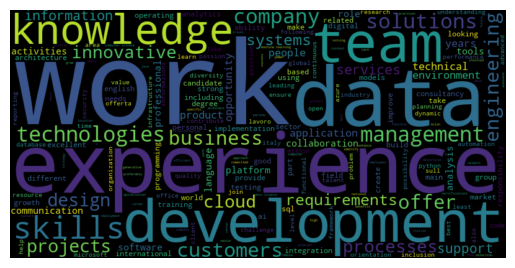

In [ ]:
generate_word_cloud(c)

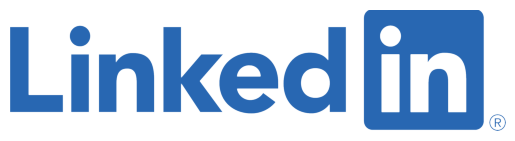

In [ ]:
# load image
linkedin_mask = np.array(Image.open(r"C:\Users\simon\Desktop\d.png"))

# display image
plt.imshow(linkedin_mask, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis('off')
plt.show()

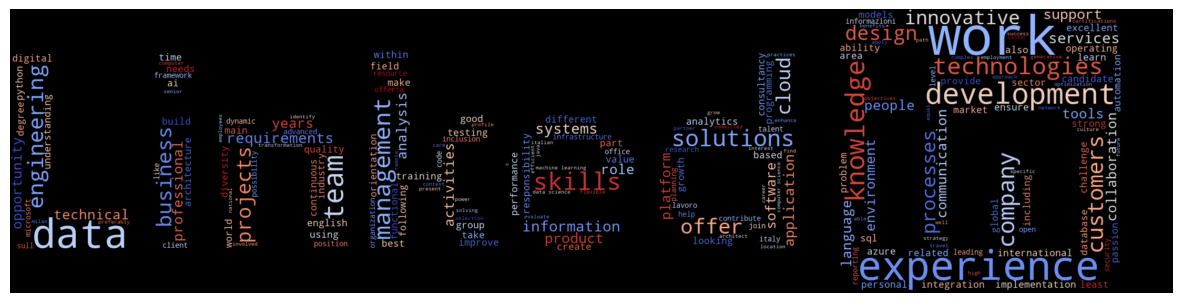

In [ ]:
def generate_word_cloud(c, image_filename=None):
    linkedin_mask = np.array(Image.open(r"C:\Users\simon\Desktop\d.png"))
    wc = WordCloud(mask=linkedin_mask,
                   background_color='black',
                   colormap='coolwarm').generate_from_frequencies(c)

    fig, ax = plt.subplots(1, 1, figsize=(15, 20))
    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")
    plt.show()

generate_word_cloud(c)

### Dispersion plot

In [ ]:
nltk_text = nltk.Text(df['token_job_description_normalized'].sum())

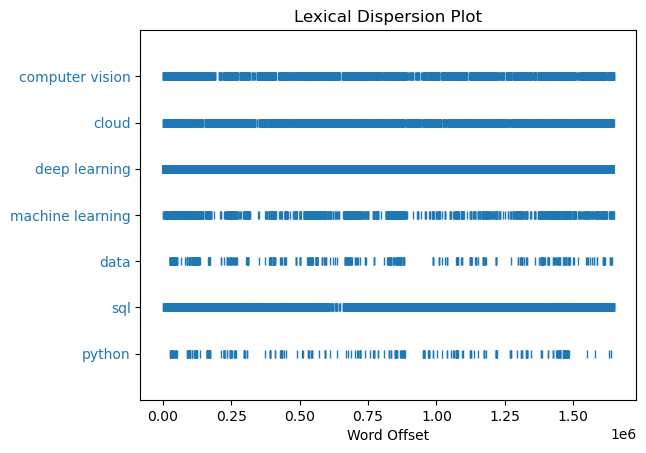

In [ ]:
nltk_text.dispersion_plot(['python','sql','data','machine learning','deep learning','cloud','computer vision'])

### Collocation

In [ ]:
def collocation(tokenized_text):
    nltk_text = nltk.Text(tokenized_text)
    return nltk_text.collocation_list()

df['collocations']=df['token_job_description_normalized'].apply(collocation) # sequenza di parole che appare più frequentemente di quanto ci si può aspettare di norma

In [ ]:
df['collocations'][2]

[('power', 'center'), ('manager', 'component'), ('workflow', 'manager')]

In [ ]:
tot_collocations=[]
for i in range(len(df['collocations'])):
    tot_collocations=tot_collocations+df['collocations'][i]

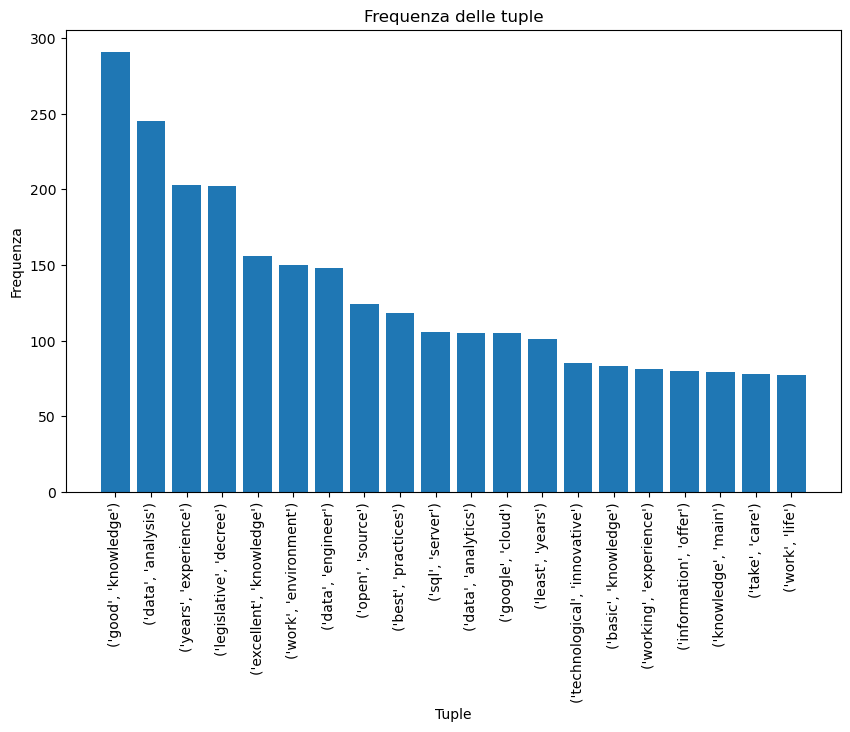

In [ ]:
counter = Counter(tot_collocations)

# Estrai le tuple e le loro frequenze, ordinate per frequenza
tuples, frequencies = zip(*counter.most_common(20))

# Crea il grafico a istogramma

plt.figure(figsize=(10, 6))
plt.bar(range(len(frequencies)), frequencies)
plt.xlabel('Tuple')
plt.ylabel('Frequenza')
plt.title('Frequenza delle tuple')
plt.xticks(range(len(tuples)), [str(t) for t in tuples], rotation=90)
plt.show()

# CLUSTERING

## Clustering su Role Description

In [ ]:
pipeline=Pipeline([('vect', CountVectorizer(analyzer='word', min_df=5)),('tfidf',TfidfTransformer()),])
X=pipeline.fit_transform(df['role_description'])

In [ ]:
X.shape

In [ ]:
if scipy.sparse.issparse(X):
    X = X.toarray()

D = squareform(pdist(X))

sse_list = list()
sil_list = list()
max_k = 30
for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=0)
    kmeans.fit(X)
    sse_list.append(kmeans.inertia_)
    sil_list.append(silhouette_score(D, kmeans.labels_, metric='precomputed'))

In [ ]:
plt.figure(figsize=(10,4))
fig, ax1 = plt.subplots()

ax1.plot(range(2, max_k + 1), sse_list, marker='.')
ax1.set_ylabel('SSE')

ax2 = ax1.twinx()
ax2.plot(range(2, max_k + 1), sil_list, marker='*', c='r')
ax2.set_ylabel('Silhouette')

plt.xlabel('k')
plt.xticks(range(2, max_k + 1))
plt.grid()
plt.show()

In [ ]:
# il num ottimale dei cluster può cambiare, quindi controlla con il grafico sopra

cluster=KMeans(n_clusters=13)
labels=cluster.fit_predict(X)

In [ ]:
# PCA

if scipy.sparse.issparse(X):
    X = X.toarray()

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')

plt.xlabel('Componente principale 1')
plt.ylabel('Componente principale 2')
plt.title('Grafico di dispersione con etichette di clustering')

cbar = plt.colorbar(scatter)
cbar.set_label('Etichette di clustering')

legend_labels = [f'Cluster {i}' for i in range(cluster.n_clusters)]
scatter.legend_elements()
handles, _ = scatter.legend_elements(prop="colors")
plt.legend(handles, legend_labels, title="Cluster")

plt.show()

In [ ]:
df['label']=cluster.labels_

In [ ]:
df['label'].value_counts()

### Possiamo vedere che tipi di lavori sono presenti per ogni cluster e i più frequenti

In [ ]:
cluster_diz = {label: [] for label in df['label'].unique()}
print(cluster_diz)

In [ ]:
for i in df['label'].unique():
    for a in df[df['label']==i]['title_sum']:
        cluster_diz[i].append(a)

In [ ]:
for i in cluster_diz:
    freq_dist = nltk.FreqDist(cluster_diz[i])
    print('Cluster', i)
    freq_dist.plot(10)

### Dai titoli presenti nel cluster si vede che ci sono altri lavori che vanno tolti

In [ ]:
# ogni volta le labels dei cluster da togliere cambiano, quindi vanno cambiate

labels=[8]

indici_da_rimuovere=df.index[df['label'].isin(labels)].tolist()

df.drop(indici_da_rimuovere, axis=0, inplace=True)

## Ora rifacciamo i cluster senza gli outliers di prima

In [ ]:
pipeline=Pipeline([('vect', CountVectorizer(analyzer='word', min_df=5)),('tfidf',TfidfTransformer()),])
X=pipeline.fit_transform(df['role_description'])

In [ ]:
if scipy.sparse.issparse(X):
    X = X.toarray()

D = squareform(pdist(X))

sse_list = list()
sil_list = list()
max_k = 30
for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=0)
    kmeans.fit(X)
    sse_list.append(kmeans.inertia_)
    sil_list.append(silhouette_score(D, kmeans.labels_, metric='precomputed'))

<Figure size 1000x400 with 0 Axes>

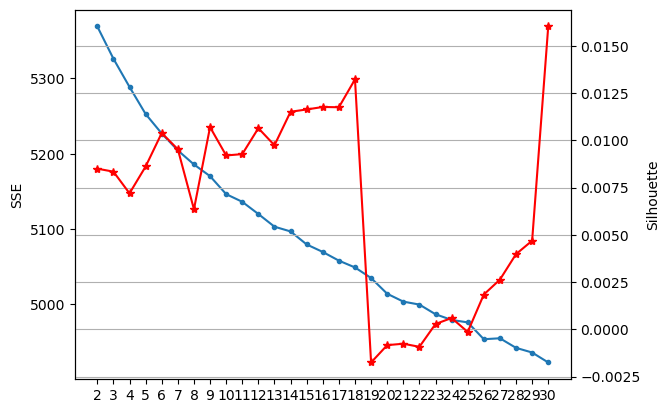

In [ ]:
plt.figure(figsize=(10,4))
fig, ax1 = plt.subplots()

ax1.plot(range(2, max_k + 1), sse_list, marker='.')
ax1.set_ylabel('SSE')

ax2 = ax1.twinx()
ax2.plot(range(2, max_k + 1), sil_list, marker='*', c='r')
ax2.set_ylabel('Silhouette')

plt.xlabel('k')
plt.xticks(range(2, max_k + 1))
plt.grid()
plt.show()

In [ ]:
# il num ottimale dei cluster può cambiare, quindi controlla con il grafico sopra

cluster=KMeans(n_clusters=12)
labels=cluster.fit_predict(X)

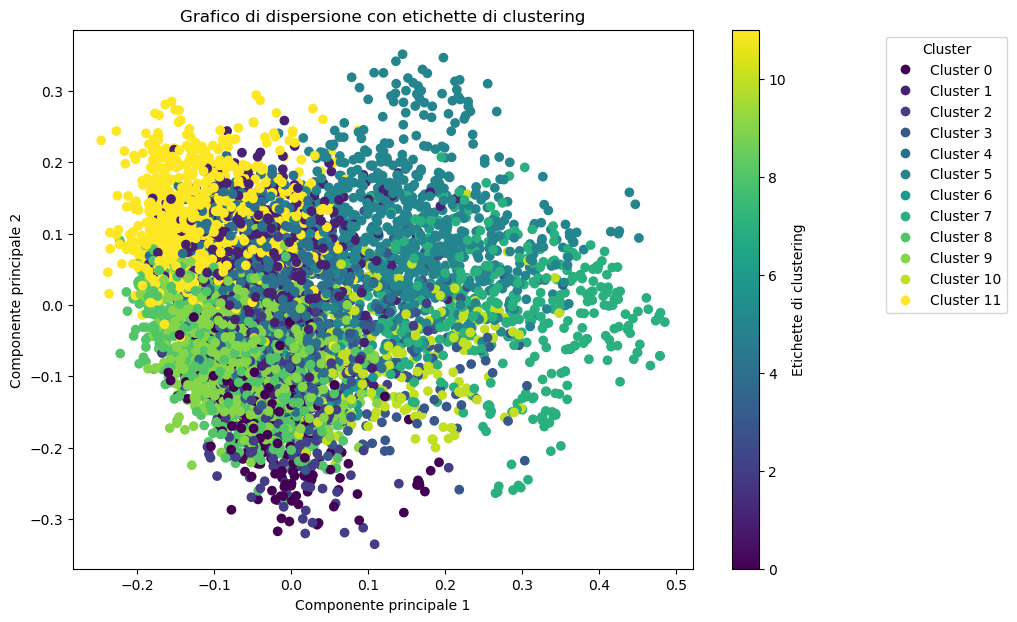

In [ ]:
if scipy.sparse.issparse(X):
    X = X.toarray()

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')

plt.xlabel('Componente principale 1')
plt.ylabel('Componente principale 2')
plt.title('Grafico di dispersione con etichette di clustering')

cbar = plt.colorbar(scatter)
cbar.set_label('Etichette di clustering')

legend_labels = [f'Cluster {i}' for i in range(cluster.n_clusters)]
scatter.legend_elements()
handles, _ = scatter.legend_elements(prop="colors")
plt.legend(handles, legend_labels, title="Cluster", bbox_to_anchor=(1.3, 1), loc='upper left')
plt.show()

In [ ]:
df['label2']=cluster.labels_

In [ ]:
df['label2'].value_counts()

label2
9     1124
11     879
4      826
5      804
8      761
1      668
7      418
2      307
0      300
10     248
3      222
6       49
Name: count, dtype: int64

In [ ]:
cluster_diz = {label: [] for label in sorted(df['label2'].unique())}
print(cluster_diz)

{0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: [], 11: []}


In [ ]:
for i in df['label2'].unique():
    for a in df[df['label2']==i]['title_sum']:
        cluster_diz[i].append(a)

Cluster 0


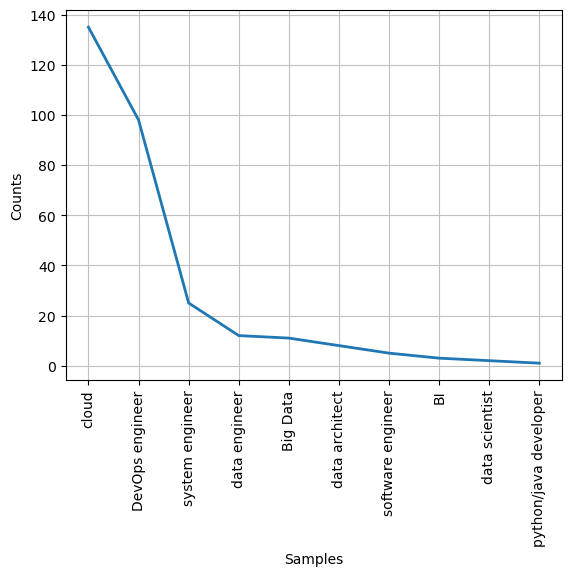

Cluster 1


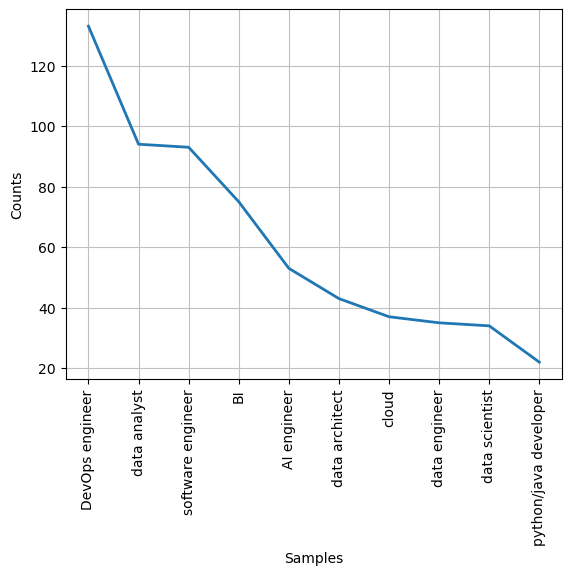

Cluster 2


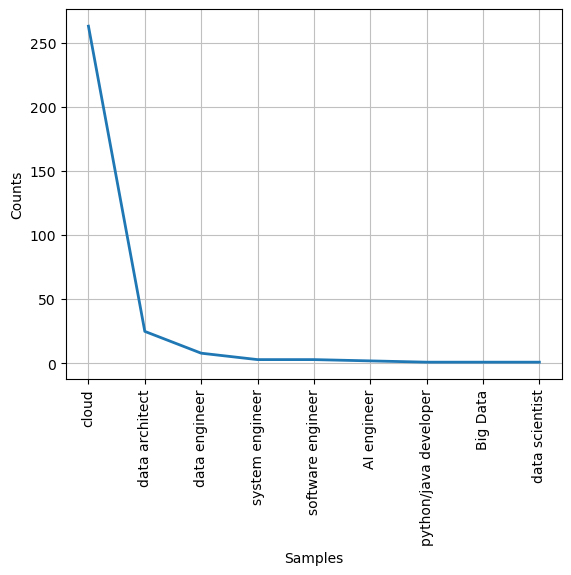

Cluster 3


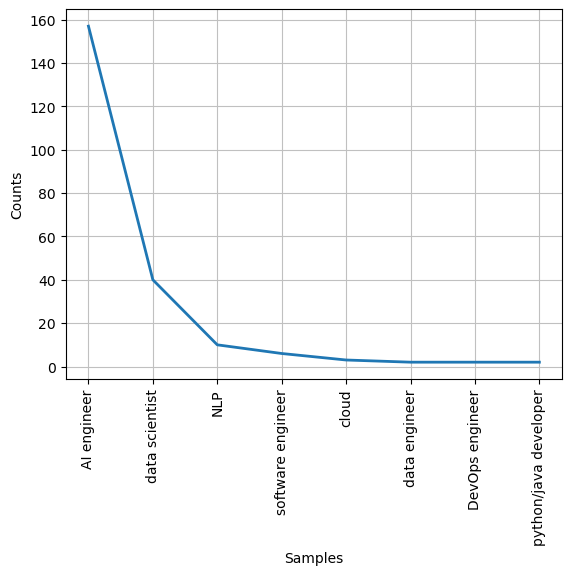

Cluster 4


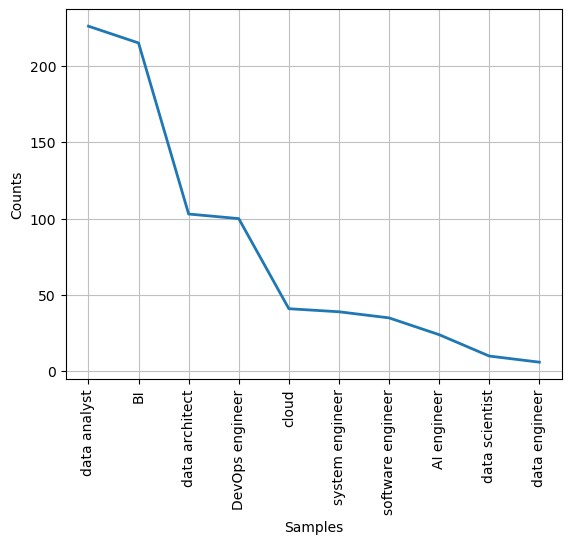

Cluster 5


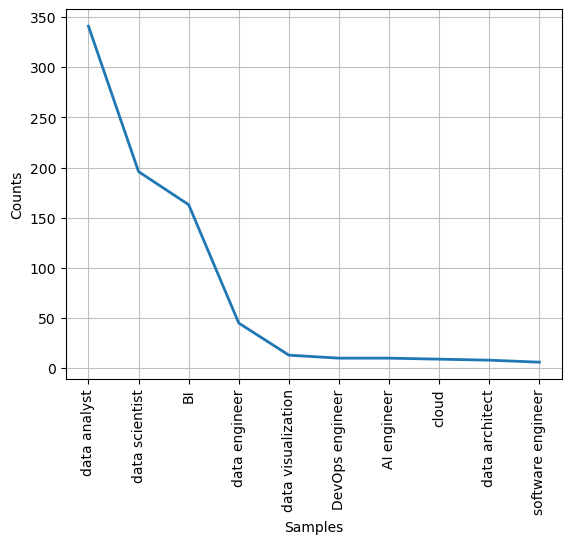

Cluster 6


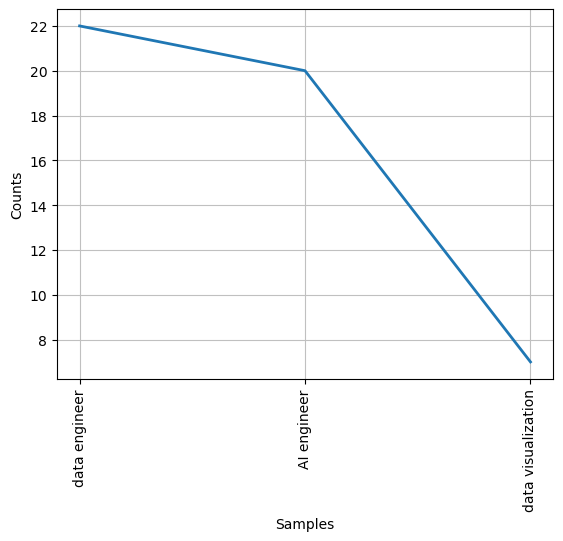

Cluster 7


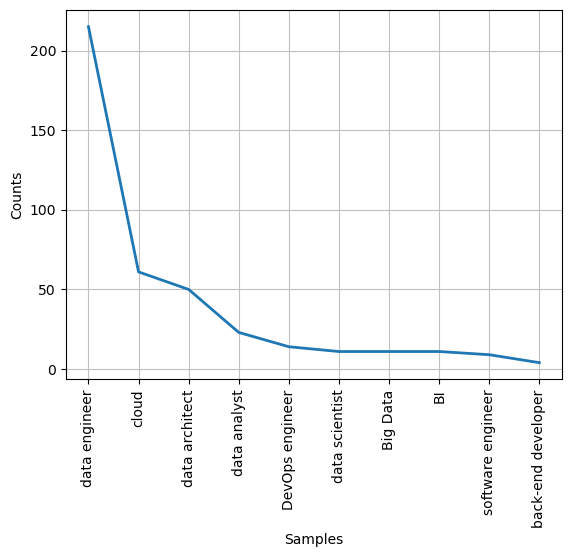

Cluster 8


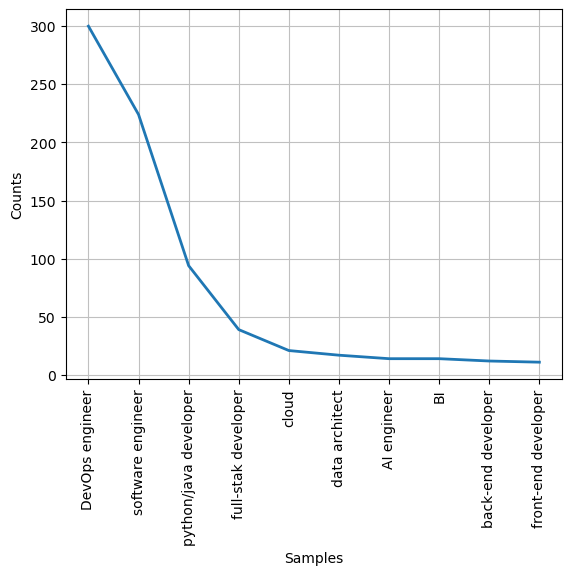

Cluster 9


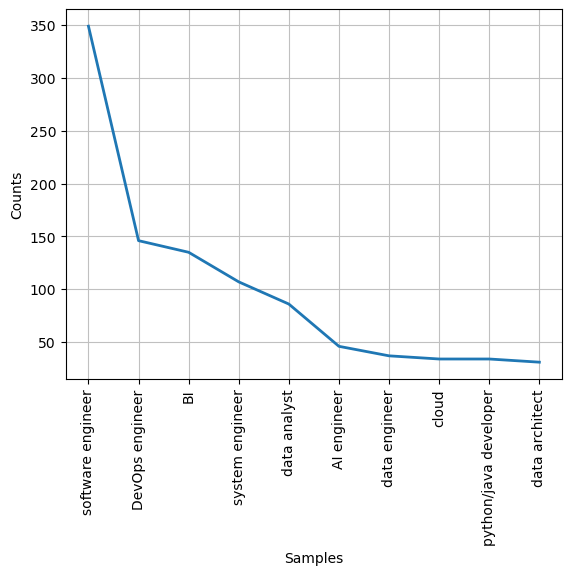

Cluster 10


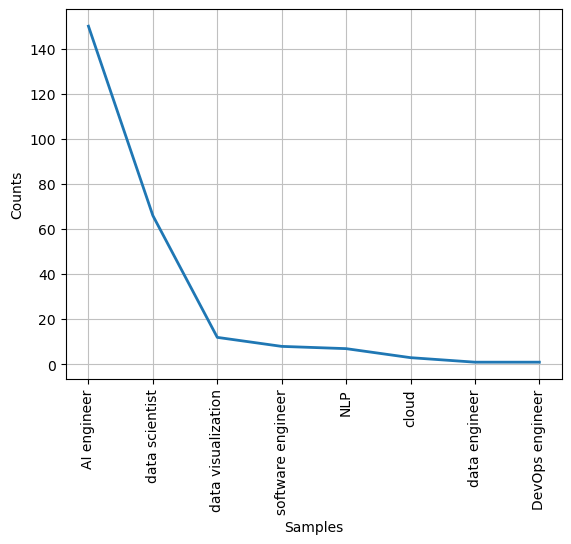

Cluster 11


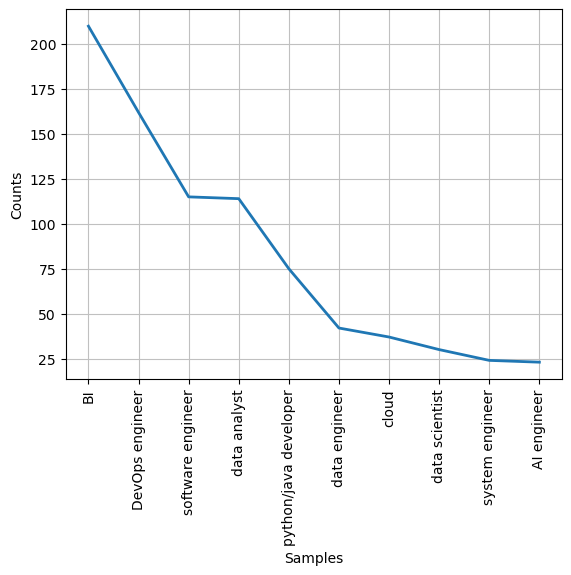

In [ ]:
for i in cluster_diz:
    freq_dist = nltk.FreqDist(cluster_diz[i])
    print('Cluster', i)
    freq_dist.plot(10)

### DV job titles clustering

In [ ]:
c_labels=[]
c_title=[]
c_frequenza=[]

In [ ]:
for i in cluster_diz:
    freq=nltk.FreqDist(cluster_diz[i])
    for tit,freq in freq.items():
        c_labels.append(i)
        c_title.append(tit)
        c_frequenza.append(freq)

In [ ]:
df_cluster = pd.DataFrame({"label": c_labels, "Job title": c_title, "freq": c_frequenza})

In [ ]:
for i in df_cluster['label'].unique():
    freq_tot_cluster=df_cluster.loc[df_cluster['label']==i]['freq'].sum()
    for index,row in df_cluster.iterrows():
        if row['label']==i:
            df_cluster.at[index,'freq_rel']=round(row['freq']/freq_tot_cluster, 4)

In [ ]:
df_cluster['freq_rel']=pd.to_numeric(df_cluster['freq_rel']).astype(float)

In [ ]:
# Visualizzazione dimensione cluster

In [ ]:
Cluster=[]
Size=[]
grandezza_vs_df=[]

In [ ]:
for i in sorted(df_cluster['label'].unique()):
    sum_f=df_cluster[df_cluster['label']==i]['freq'].sum()
    Cluster.append(i)
    Size.append(sum_f)


In [ ]:
df_grandezza_clust=pd.DataFrame({'Cluster':Cluster , 'Size':Size})

In [ ]:
for i in df_grandezza_clust['Size']:
    grandezza_vs_df.append(round(i/len(df),2))

In [ ]:
df_grandezza_clust['grandezza_vs_df']=grandezza_vs_df

In [ ]:
chart=alt.Chart(df_grandezza_clust).mark_bar(size=15, tooltip=True).encode(
    alt.Y('grandezza_vs_df:Q', title=None),
    alt.X('Cluster:N', axis=alt.Axis(labelAngle=0)),
    color=alt.Color('Origin:N', legend=None),
    tooltip=[alt.Tooltip('Cluster:N', title='Cluster'), alt.Tooltip('grandezza_vs_df:Q', title='Cluster size vs DataFrame', format='.2%')]
).properties(title={'text':'Cluster size'} )
chart.display()

alt.Chart(...)

In [ ]:
chart_json = chart.to_json()
with open(fr'C:\Users\simon\Desktop\chart_dimensionecluster_istogrammi.json', 'w') as f:
    f.write(chart_json)

In [ ]:
# soglia per istogrammi nei cluster (2%)

for ind, row in df_cluster.iterrows():
    if row['freq_rel'] < 0.02:
        df_cluster.drop(ind,axis=0,inplace=True)

In [ ]:
df_cluster = df_cluster.reset_index(drop=True)

In [ ]:
df_cluster['nr cluster']='Cluster '+df_cluster['label'].astype(str)

In [ ]:
# visualizzazione cluster con menù a tendina

input_dropdown = alt.binding_select(options=sorted(df_cluster['label'].unique()), name='Cluster ')
selection = alt.selection_point(fields=['label'], bind=input_dropdown,  value=[{'label':min(df_cluster.label)}])
color = alt.condition(
    selection,
    alt.Color('Origin:N').legend(None),
    alt.value('lightgray')
)


chart=alt.Chart(df_cluster).mark_bar(tooltip=True).encode(
        alt.Y('Job title:N', title=None, axis=alt.Axis(labelAngle=0), sort=alt.SortField(field='freq_rel', order='descending')),
        alt.X('freq_rel:Q', title='Frequency',scale=alt.Scale(domain=[0,1])),
        #alt.Color('Job title:N', scale=alt.Scale(scheme='category20')),
        color=color,
        tooltip=[alt.Tooltip('Job title:N', title='Job title'), alt.Tooltip('freq_rel:Q', title='Percentage', format='.1%')]
).properties(title='Job title analysis').transform_filter(selection).configure_legend(disable=True).add_params(selection)

chart.display()

alt.Chart(...)

In [ ]:
# Salvataggio del grafico come file JSON
chart_json = chart.to_json()
with open(r'C:\Users\simon\Desktop\chart.json', 'w') as f:
    f.write(chart_json)


In [ ]:
# Visualizzazione cluster in un'unica immagine

chart = alt.Chart(df_cluster).mark_bar(tooltip=True).encode(
        alt.Y('Job title:N', title=None, axis=alt.Axis(labelAngle=0),
              sort=alt.SortField(field='freq_rel', order='descending')),
        alt.X('freq_rel:Q', title='Frequency', scale=alt.Scale(domain=[0, 1])),
        tooltip=[alt.Tooltip('Job title:N', title='Job title'),
                 alt.Tooltip('freq_rel:Q', title='Percentage', format='.2%')],

        facet=alt.Facet('nr cluster:N', columns=3, align='each', spacing=20, title=None, sort={"field": "label"})

    ).properties(title={'text':'Job title distribution by cluster', 'anchor': 'middle', 'offset': 30},width=200).resolve_scale(
    x='independent', y='independent').configure_legend(disable=True)

chart

alt.Chart(...)

In [ ]:
# Salvataggio del grafico come file JSON
chart_json = chart.to_json()
with open(r'C:\Users\simon\Desktop\chart_clust.json', 'w') as f:
    f.write(chart_json)

## Clustering su TagMe (non utilizzato)

In [ ]:
pipeline2=Pipeline([('vect', CountVectorizer(analyzer='word', min_df=5)),('tfidf',TfidfTransformer()),])
X2=pipeline2.fit_transform(df['TM2'])

In [ ]:
X2.shape

In [ ]:
if scipy.sparse.issparse(X2):
    X2 = X2.toarray()

D = squareform(pdist(X2))

sse_list = list()
sil_list = list()
max_k = 30
for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=0)
    kmeans.fit(X2)
    sse_list.append(kmeans.inertia_)
    sil_list.append(silhouette_score(D, kmeans.labels_, metric='precomputed'))

In [ ]:
plt.figure(figsize=(10,4))
fig, ax1 = plt.subplots()

ax1.plot(range(2, max_k + 1), sse_list, marker='.')
ax1.set_ylabel('SSE')

ax2 = ax1.twinx()
ax2.plot(range(2, max_k + 1), sil_list, marker='*', c='r')
ax2.set_ylabel('Silhouette')

plt.xlabel('k')
plt.xticks(range(2, max_k + 1))
plt.grid()
plt.show()

In [ ]:
cluster2=KMeans(n_clusters=14)
labels2=cluster2.fit_predict(X2)

In [ ]:
# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X2)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels2, cmap='viridis')

plt.xlabel('Componente principale 1')
plt.ylabel('Componente principale 2')
plt.title('Grafico di dispersione con etichette di clustering')

cbar = plt.colorbar(scatter)
cbar.set_label('Etichette di clustering')

legend_labels = [f'Cluster {i}' for i in range(cluster2.n_clusters)]
scatter.legend_elements()  # Ottieni gli elementi della legenda
handles, _ = scatter.legend_elements(prop="colors")
plt.legend(handles, legend_labels, title="Cluster")

plt.show()

In [ ]:
df['label_TagMe']=cluster2.labels_

In [ ]:
cluster_diz2 = {label: [] for label in df['label_TagMe'].unique()}
print(cluster_diz2)

In [ ]:
for i in df['label_TagMe'].unique():
    for a in df[df['label_TagMe']==i]['title_sum']:
        cluster_diz2[i].append(a)

In [ ]:
for i in cluster_diz2:
    freq_dist = nltk.FreqDist(cluster_diz2[i])
    print('Cluster', i)
    freq_dist.plot(10)

# LinkedIN SKILLSLIST PER OGNI CLUSTER

In [ ]:
diz_sl={}
for i in df['label2'].unique():
    cluster_skills=df.loc[df['label2']==i, 'skillsList']
    skills_list=[]
    for skills in cluster_skills:
        if skills is not np.nan:
            skills_list.extend(skills.split(', '))
    diz_sl[f'Cluster {i}']=pd.Series(skills_list)

# Calcola la frequenza di ogni competenza
diz_sl_freq={}
for i in diz_sl:
    diz_sl_freq[i] = diz_sl[i].value_counts()

Cluster 5


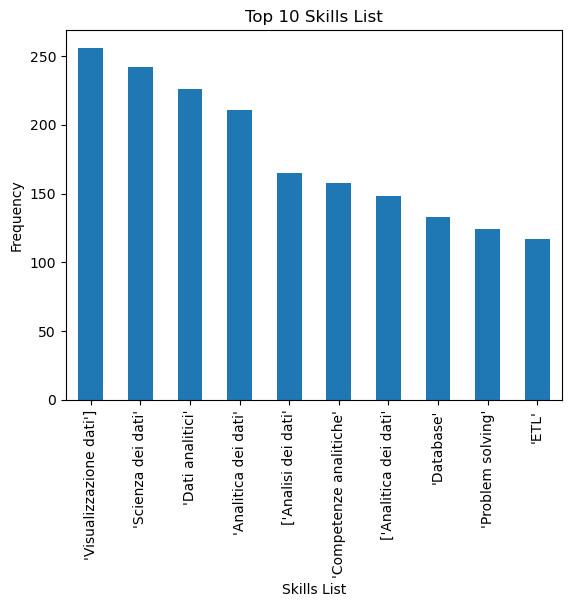

Cluster 4


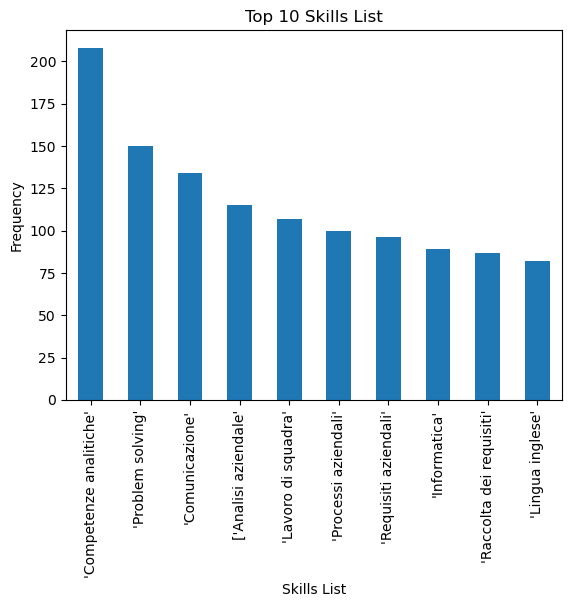

Cluster 1


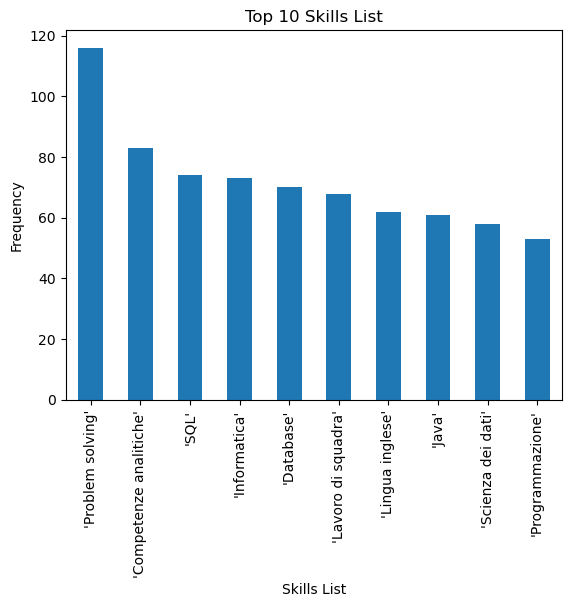

Cluster 11


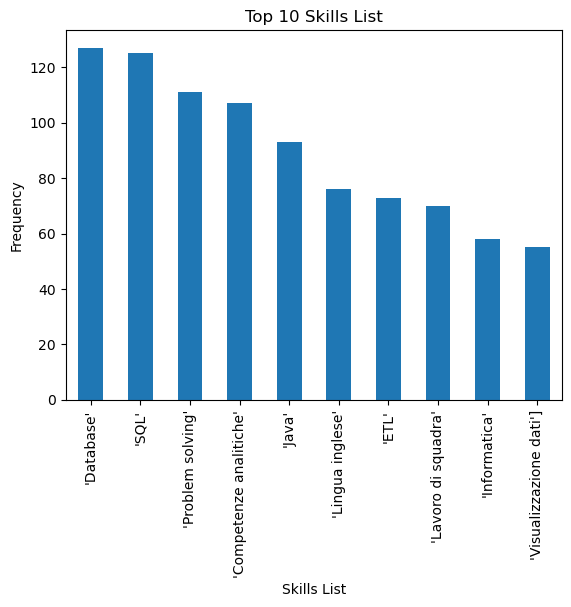

Cluster 9


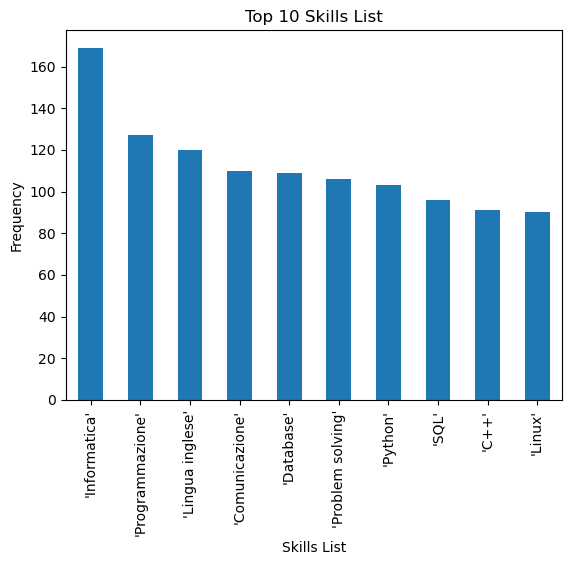

Cluster 7


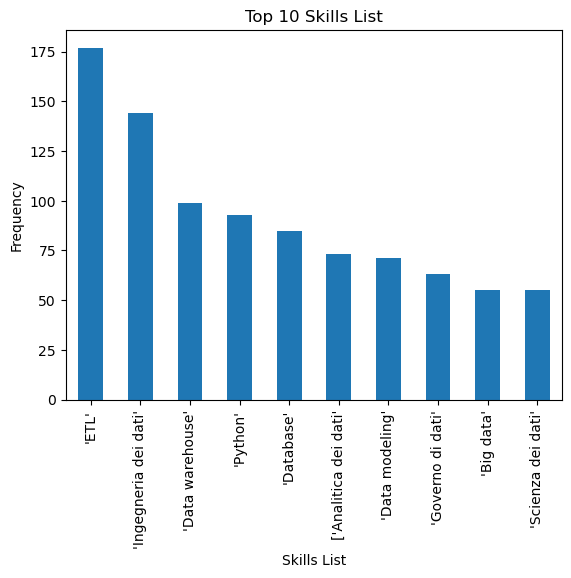

Cluster 10


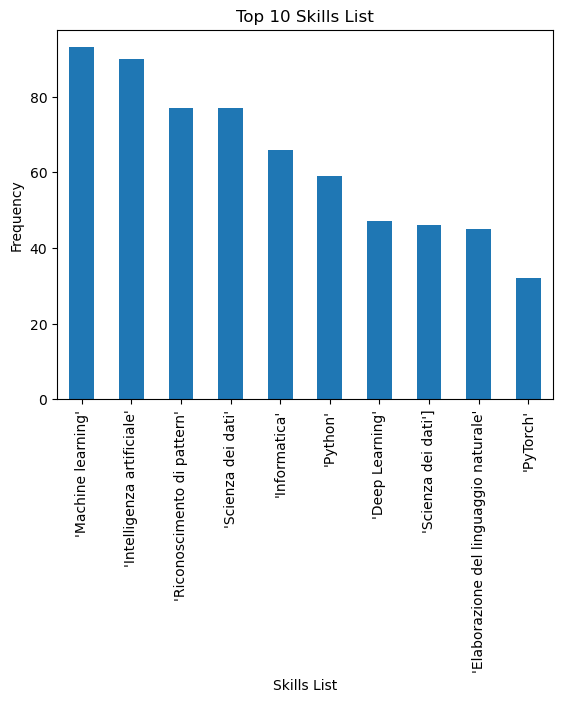

Cluster 0


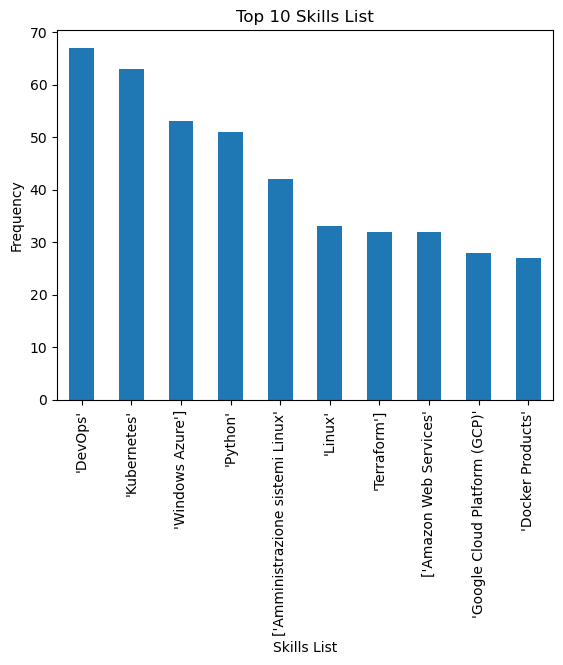

Cluster 3


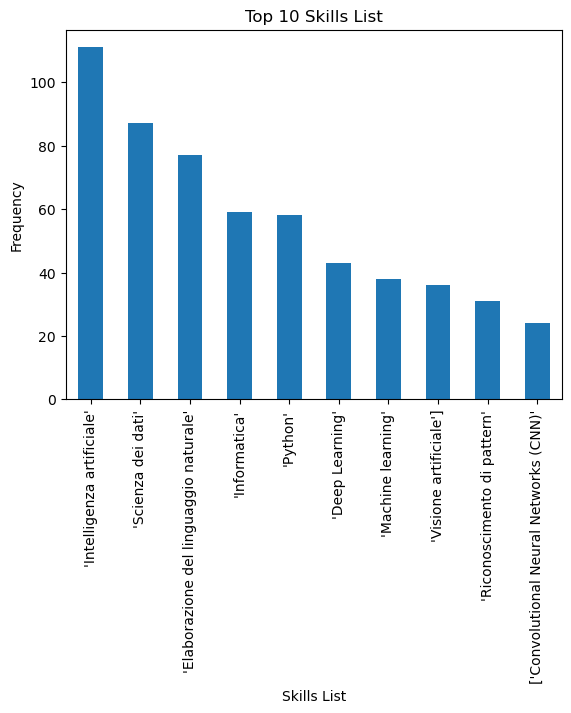

Cluster 6


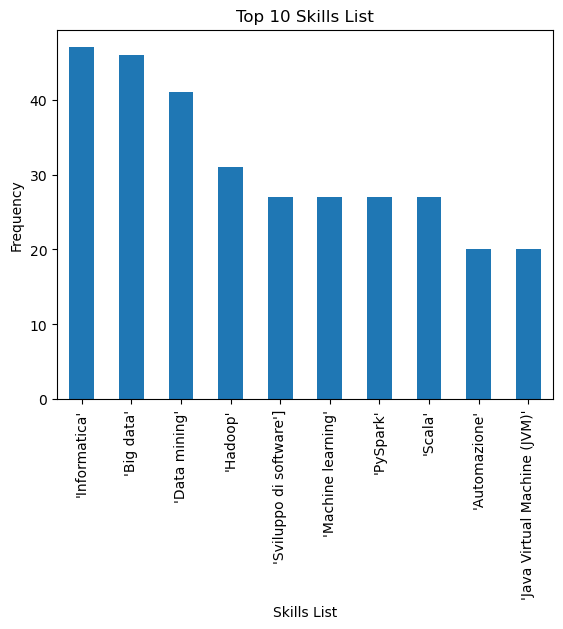

Cluster 8


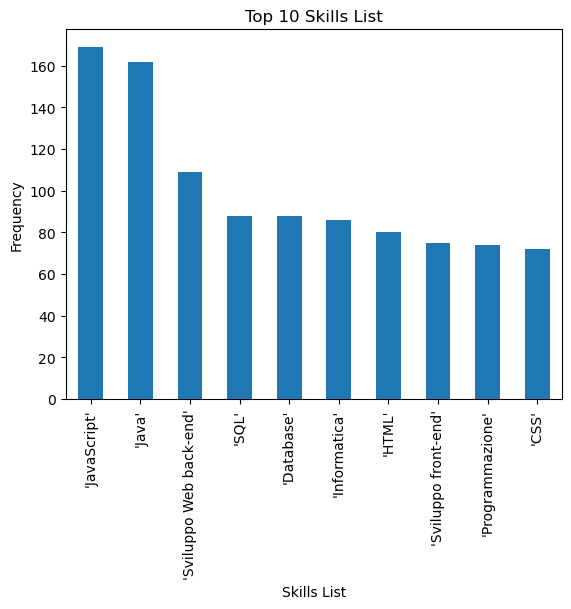

Cluster 2


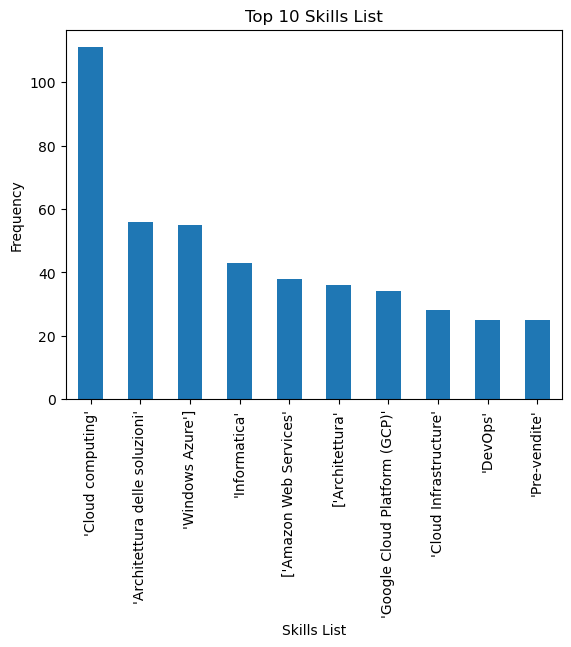

In [ ]:
for i in diz_sl_freq:
    print(i)
    diz_sl_freq[i][:10].plot(kind='bar')
    plt.title('Top 10 Skills List')
    plt.xlabel('Skills List')
    plt.ylabel('Frequency')
    plt.show()

In [ ]:
df_altair=df[['label2', 'skillsList']]

In [ ]:
type(df['skillsList'])

pandas.core.series.Series

In [ ]:
is_list_column = df_altair['skillsList'].apply(lambda x: isinstance(x, list))

In [ ]:
def ensure_list(x):
    if isinstance(x, list):
        return x
    elif isinstance(x, str):
        return x.split(', ')
    else:
        return [x]

In [ ]:
df_altair['skillsList'] = df['skillsList'].apply(ensure_list)

In [ ]:
df_altair_explose=df_altair.explode('skillsList', ignore_index=True)

In [ ]:
type(df_altair_explose['skillsList'])

pandas.core.series.Series

In [ ]:
def pulisci_stringhe(val):
    if val is None or pd.isna(val):
        return val
    elif isinstance(val, str):
        return re.sub(r"[\'\[\]\(\)]", "", val).strip()
    return val

df_altair_explose['skillsList']=df_altair_explose['skillsList'].apply(pulisci_stringhe)

In [ ]:
diz_altair={}
for i in df_altair_explose['label2'].unique():
    diz_altair[i]=df_altair_explose[df_altair_explose['label2']==i]['skillsList'].value_counts().head(10)

In [ ]:
labels = []
skillslist = []
frequenza = []

In [ ]:
for k,v in diz_altair.items():
    for skill, count in v.items():
        labels.append(k)
        skillslist.append(skill)
        frequenza.append(count)

df_value_counts = pd.DataFrame({"label": labels, "LinkedIn Skills List": skillslist, "frequenza": frequenza})

In [ ]:
for i in df_value_counts['label'].unique():
    freq_tot=df_value_counts.loc[df_value_counts['label']==i]['frequenza'].sum()
    for index,row in df_value_counts.iterrows():
        if row['label']==i:
            df_value_counts.at[index,'freq_rel']=round(row['frequenza']/freq_tot, 4)

In [ ]:
input_dropdown = alt.binding_select(options=sorted(df_value_counts['label'].unique()), name='Cluster ')
selection = alt.selection_point(fields=['label'], bind=input_dropdown)
color = alt.condition(
    selection,
    alt.Color('Origin:N').legend(None),
    alt.value('lightgray')
)


alt.Chart(df_value_counts).mark_bar(tooltip=True).encode(
        alt.Y('LinkedIn Skills List:N',title=None, axis=alt.Axis(labelAngle=0), sort=alt.SortField(field='freq_rel', order='descending')),
        alt.X('freq_rel:Q', title='Frequency',scale=alt.Scale(domain=[0, 0.5]) ),
        #alt.Color('Job title:N', scale=alt.Scale(scheme='category20')),
        color=color,
        tooltip=[alt.Tooltip('LinkedIn Skills List:N', title='LinkedIn Skills List'), alt.Tooltip('freq_rel:Q', title='Percentage', format='.2%')]
).properties(title='LinkedIn skills list anaysis').transform_filter(selection).add_params(selection).display()

alt.Chart(...)

In [ ]:
diz_c={}
for i in df['label'].unique():
    cluster_collocations=df.loc[df['label']==i, 'collocations']
    collocations_list=[]
    for coll in cluster_collocations:
        collocations_list.extend(coll)
    diz_c[f'cluster {i}'] = pd.Series(Counter(collocations_list))

In [ ]:
diz_c_freq={}
for i in diz_c:
    diz_c_freq[i] = diz_c[i].value_counts(10)

In [ ]:
# Creiamo un grafico a barre delle competenze più comuni
for i in diz_c_freq:
    print(i)
    diz_c_freq[i][:10].plot(kind='bar')
    plt.title('Top 10 Skills List')
    plt.xlabel('collocations')
    plt.ylabel('Frequency')
    plt.show()

# ESTRAIAMO LE HARD / SOFT SKILLS PER OGNI CLUSTER

### Soft skills

In [ ]:
df_ss=pd.read_csv(r'C:\Users\simon\Desktop\excel progetto uni\softskills.csv')

In [ ]:
df['softskills'] = ''


for idx, row in df.iterrows():
    skills_list = row['role_description']

    for skill in df_ss['Skill']:
        if skill in skills_list:
            df.at[idx, 'softskills'] += skill + ', '

df['softskills'] = df['softskills'].str.rstrip(', ')

In [ ]:
skills_list = {
    'ability to plan':'planning skills',
    'strategic planning':'planning skills',
    'work collaboratively':'ability to work collaboratively',
    'make decision':'ability to make decisions',
    'decision maker':'ability to make decisions',
    'ability to negotiate':'negotiation skills',
    'ability to listen':'listening skills',
    'commitment to accountability':'accountability',
    'client oriented':'customer orientation',
    'client relationships':'customer orientation',
    'work under pressure':'ability to work under pressure',
    'able to work under pressure':'ability to work under pressure',
    'active personality':'active person',
    'presentation':'ability to effectively present information',
    'respect for diversity':'respectful',
    'able to work independently':'ability to work independently',
    'dedicated person':'dedication',
    'punctual':'punctuality',
    'ability to travel':'willing to travel',
    'willingness to travel':'willing to travel',
    'accuracy':'accurate',
    'enthusiastic':'enthusiasm',
    'project management':'project management skills',
    'attention to detail':'attention to details',
    'attentive to details':'attention to details',
    'detail oriented':'attention to details',
    'motivation':'motivated',
    'motivating':'motivated',
    'positive': 'positive attitude',
    'managerial skills':'management skills',
    'ability to manage':'management skills',
    'management skill':'management skills',
    'people management':'management skills',
    'team management': 'management skills',
    'people management skills': 'management skills',
    'leadership skills':'leadership',
    'creative thinking': 'creative',
    'creative approach': 'creative',
    'creative thinking skills': 'creative',
    'organized': 'organizational skills',
    'organized person': 'organizational skills',
    'organization skills': 'organizational skills',
    'organizational capabilities': 'organizational skills',
    'ability to organize': 'organizational skills',
    'ability to organize tasks': 'organizational skills',
    'organizer': 'organizational skills',
    'organizing skills': 'organizational skills',
    'results orientation': 'results oriented',
    'ability to achieve results': 'results oriented',
    'results driven': 'results oriented',
    'innovative thinking': 'innovative',
    'take initiative': 'ability to take initiative',
    'responsibility': 'ability to take responsibility',
    'sense of responsibility': 'ability to take responsibility',
    'responsible': 'ability to take responsibility',
    'take initiative': 'ability to take initiative',
    'flexible': 'flexibility',
    'communication skill': 'communication skills',
    'communication skill': 'communication skills',
    'ability to communicate effectively': 'communication skills',
    'ability to communicate': 'communication skills',
     'ability to communicate effectively at all levels': 'communication skills',
    'communicator': 'communication skills',
    'communicative': 'communication skills',
    'problem solving abilities': 'problem solving',
    'ability to resolve problems': 'problem solving',
    'problem solver': 'problem solving',
    'critical thinking skills': 'critical thinking',
    'ability to think critically': 'critical thinking',
    'team worker': 'team working skills',
    'teamworker': 'team working skills',
    'teamwork': 'team working skills',
    'teamwork skills': 'team working skills',
    'working in a team': 'team working skills',
    'ability to work in a team': 'team working skills',
    'work in team': 'team working skills',
    'ability to work in team': 'team working skills',
    'team work skills': 'team working skills',
    'able to work in a team': 'team working skills',
    'team player': 'team working skills',
    'work within a team': 'team working skills',
    'ability to work in a team environment': 'team working skills',
    'team spirit': 'team working skills',
    'ability to think analytically': 'analytical skills',
    'analytical thinking': 'analytical skills',
    'analytical abilities': 'analytical skills',
    'analytical mind': 'analytical skills',
    'analytical thinking skills': 'analytical skills',
    'analytical skills': 'analytical skills',
    'analysis skills': 'analytical skills',
    'ability to analyze': 'analytical skills',
    'analytic skills': 'analytical skills',
    'tactful manner': 'tact',
    'tactful': 'tact',
    'people management': 'people management skills',
    'people skills': 'people management skills',
    'time management skills': 'time management',
    'ability to manage time': 'time management',
    'work under pressure': 'ability to work under pressure',
    'able to work under pressure': 'ability to work under pressure',
    'meeting deadlines': 'ability to meet deadlines',
    'ability to prioritize': 'ability to prioritize tasks',
    'prioritization skills': 'ability to prioritize tasks',
    'able prioritize': 'ability to prioritize tasks',
    'ability to handle multiple priorities': 'ability to prioritize tasks',
    'work ethics': 'work ethic',
    'ability to learn':'learning skills',
    'eager to learn': 'learning skills',
    'quick learning': 'learning skills',
    'quick to learn':'learning skills',
    'desire to learn':'learning skills',
    'interest to learn':'learning skills',
    'desire to learn new things':'learning skills',
    ' ': np.nan,
    'proactive approach': 'proactive',
    'ability to work on multiple tasks': 'multitasking skills',
    'ability to handle multiple priorities': 'multitasking skills',
    'ability to manage multiple tasks': 'multitasking skills',
    'manage multiple tasks': 'multitasking skills',
    'problem solving orientation':'problem solving',
    'creativity':'creative thinking',
    'creative':'creative thinking',
    'creative approach':'creative thinking',
    'creative thinking skills':'creative thinking'
}

In [ ]:
for idx, row in df.iterrows():
    if isinstance(row['softskills'], str):
        skills = row['softskills'].split(', ')
        new_skills = []
        for skill in skills:
            if skill in skills_list:
                new_skill = skills_list[skill]
                if new_skill not in new_skills:
                    new_skills.append(new_skill)
            else:
                if skill not in new_skills:
                    new_skills.append(skill)

        new_skills = [skill for skill in new_skills if isinstance(skill, str)]

        df.at[idx, 'softskills'] = ', '.join(new_skills)

In [ ]:
df['softskills'].replace('', np.nan)

0       communication skills, management skills, atten...
1       ability to take responsibility, leadership, pr...
2       autonomy, ability to take responsibility, proa...
3            analytical skills, professionalism, accurate
4       initiative, attention to details, analytical s...
                              ...                        
6601                       ability to take responsibility
6602    ability to take responsibility, able to priori...
6603    organizational skills, ability to work indepen...
6604                            project management skills
6605    ability to take responsibility, articulate, ta...
Name: softskills, Length: 6606, dtype: object

In [ ]:
diz_ss={}
for i in df['label2'].unique():
    cluster_skills=df.loc[df['label2']==i, 'softskills']
    skills_list=[]
    for skills in cluster_skills:
        if skills not in (''):
            skills_list.extend(skills.split(', '))
    diz_ss[i]=pd.Series(skills_list)

diz_ss_freq={}
for i in diz_ss:
    diz_ss_freq[i] = diz_ss[i].value_counts()

Cluster 5


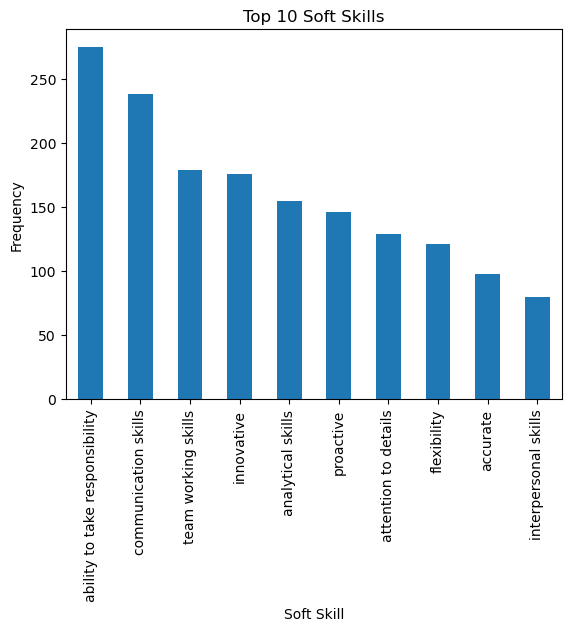

Cluster 4


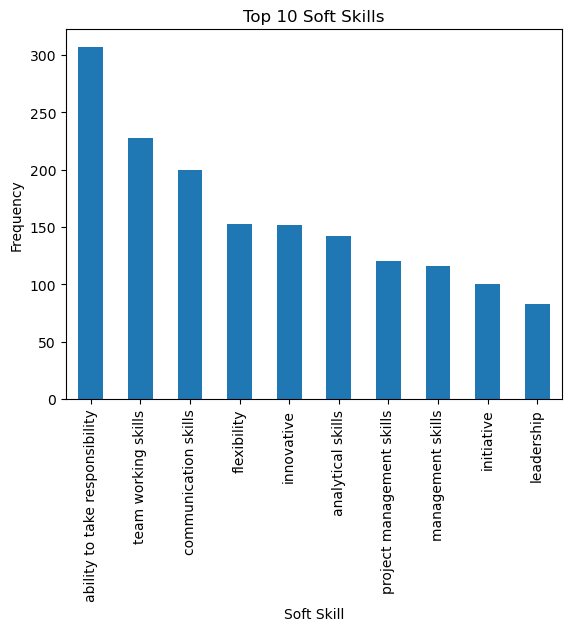

Cluster 1


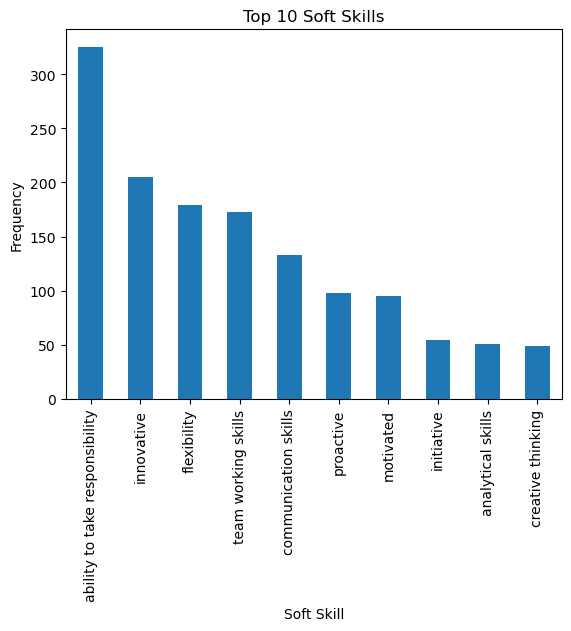

Cluster 11


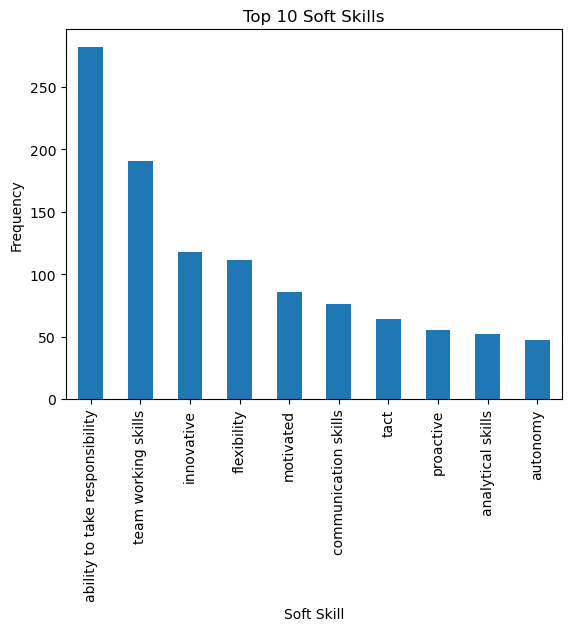

Cluster 9


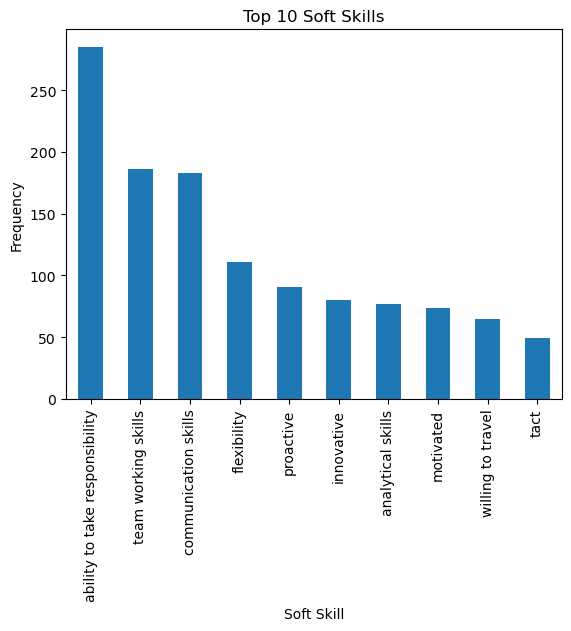

Cluster 7


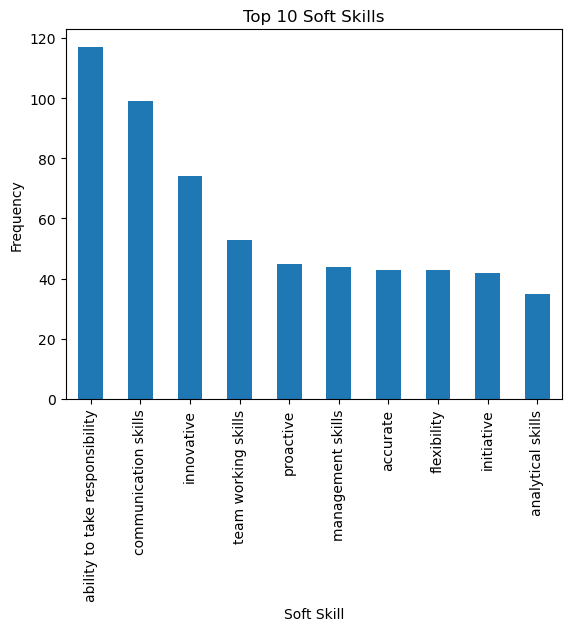

Cluster 10


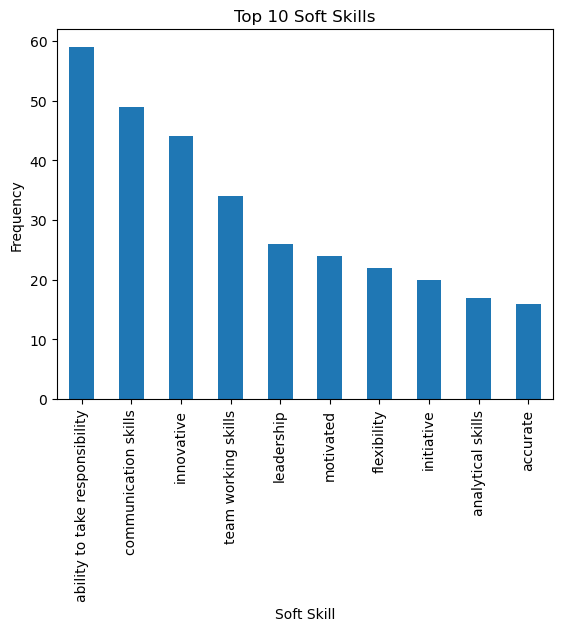

Cluster 0


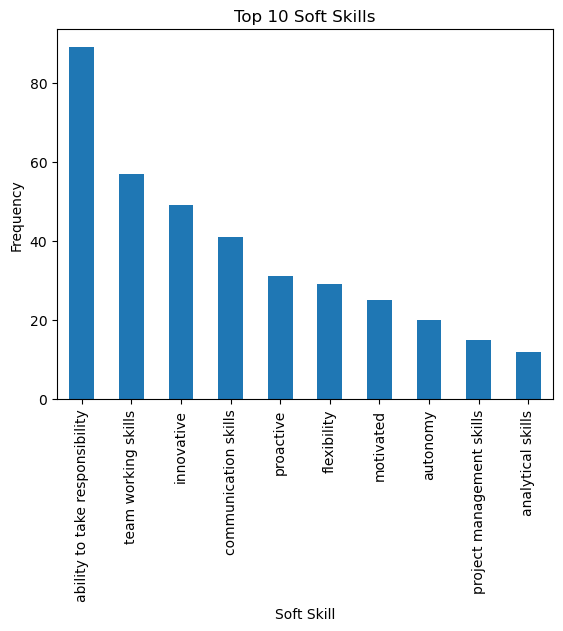

Cluster 3


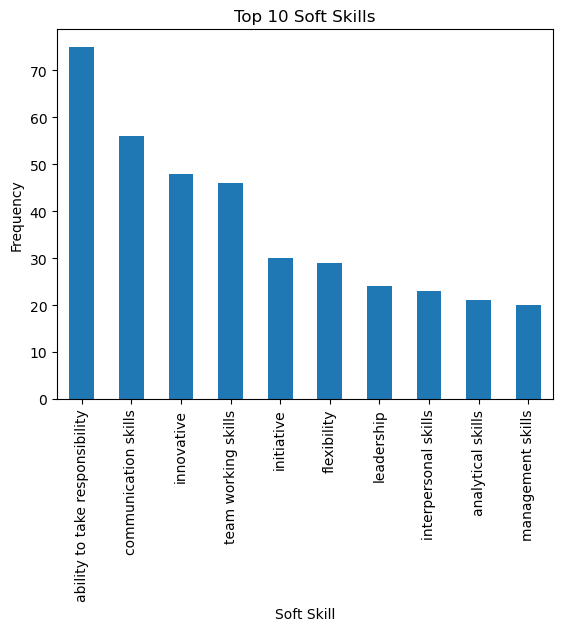

Cluster 6


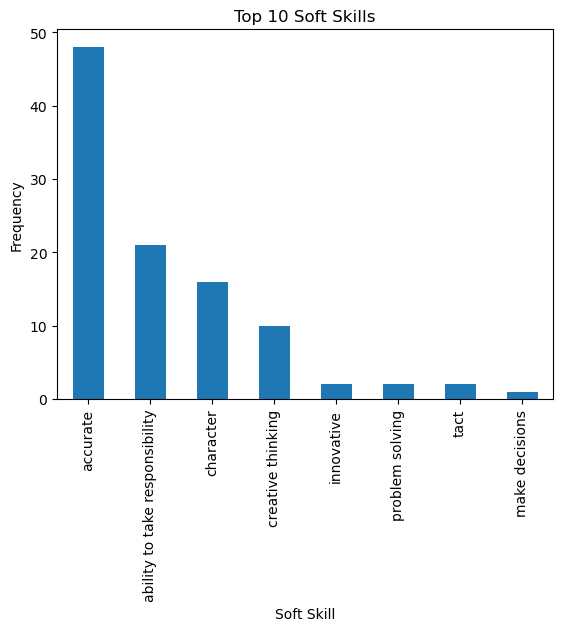

Cluster 8


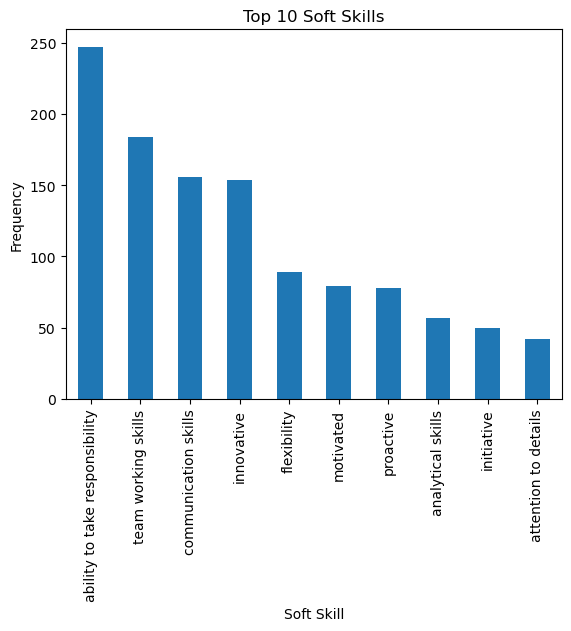

Cluster 2


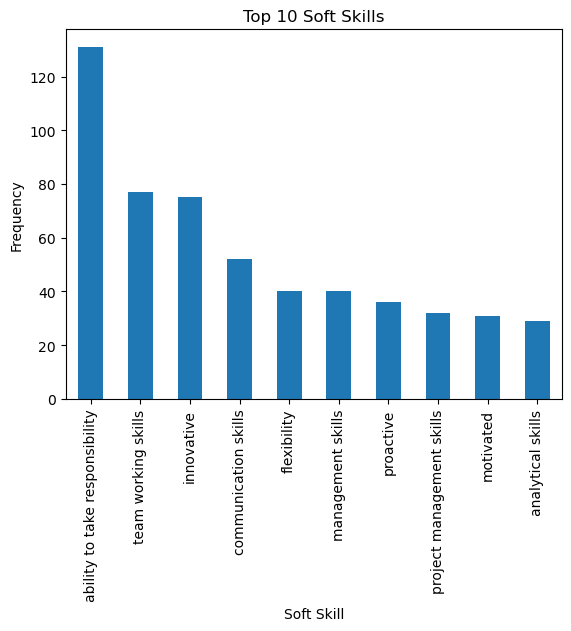

In [ ]:
for i in diz_ss_freq:
    print(f'Cluster {i}')
    diz_ss_freq[i][:10].plot(kind='bar')
    plt.title('Top 10 Soft Skills')
    plt.xlabel('Soft Skill')
    plt.ylabel('Frequency')
    plt.show()

### Hard skills

In [ ]:
df_hs=pd.read_csv(r'C:\Users\simon\Desktop\excel progetto uni\hardskills.csv')

In [ ]:
df['hardskills'] = ''

for idx, row in df.iterrows():
    skills_list = ' ' + row['role_description'] + ' '
    for skill in df_hs['hard_skill']:
        if ' ' + str(skill) + ' ' in skills_list:
            df.at[idx, 'hardskills'] += str(skill) + ', '

    if ' C ' in skills_list and 'C' not in df.at[idx, 'hardskills']:
        df.at[idx, 'hardskills'] += 'C, '
    if ' R ' in skills_list and 'R' not in df.at[idx, 'hardskills']:
        df.at[idx, 'hardskills'] += 'R, '

df['hardskills'] = df['hardskills'].str.rstrip(', ')

In [ ]:
hskills_list = {
    'statistical modeling':'statistics',
    'statistical analysis':'statistics',
    'analyze data': 'data analytics',
    'application development methodologies':'application development',
    'application development techniques':'application development',
    'application development tools':'application development',
    'database':'database management system',
    'dbms':'database management system',
    'relational databases':'database management system',
    'microsoft excel':'ms excel',
    'speak english':'english language',
    'speak french':'french language',
    'speak italian':'italian language',
    'speak german':'german language',
    'speak chinese':'chinese language',
    'business requirements':'business'
}

In [ ]:
for idx, row in df.iterrows():
    if isinstance(row['hardskills'], str):
        skills = row['hardskills'].split(', ')

        new_skills = []

        for skill in skills:

            if skill in hskills_list:

                new_skill = hskills_list[skill]

                if new_skill not in new_skills:
                    new_skills.append(new_skill)
            else:

                if skill not in new_skills:
                    new_skills.append(skill)

        new_skills = [skill for skill in new_skills if isinstance(skill, str)]
        df.at[idx, 'hardskills'] = ', '.join(new_skills)

In [ ]:
diz_hs={}
for i in df['label2'].unique():
    cluster_skills=df.loc[df['label2']==i, 'hardskills']
    skills_list=[]
    for skills in cluster_skills:
        if skills not in (''):
            skills_list.extend(skills.split(', '))
    diz_hs[i]=pd.Series(skills_list)
diz_hs_freq={}
for i in diz_hs:
    diz_hs_freq[i] = diz_hs[i].value_counts()

Cluster 5


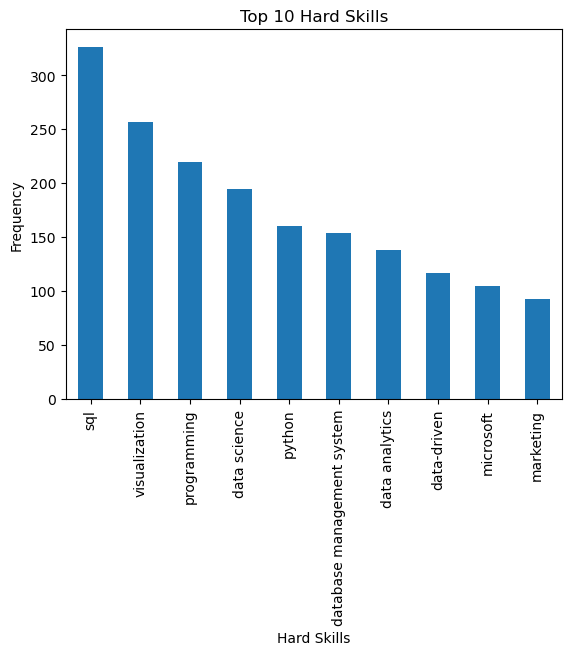

Cluster 4


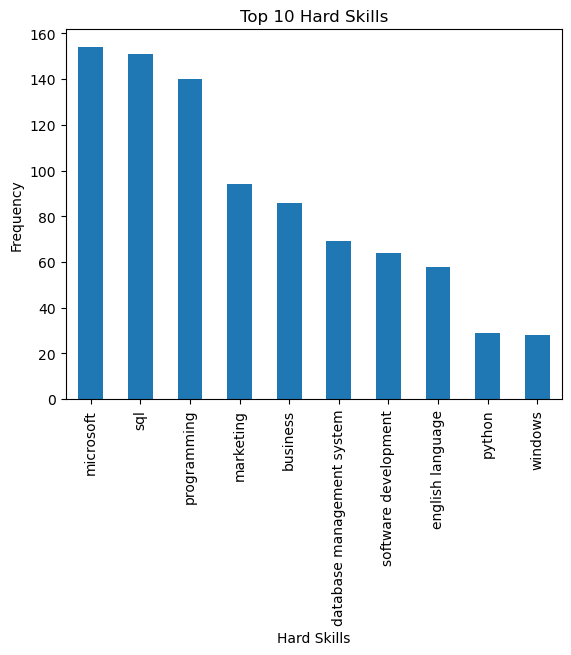

Cluster 1


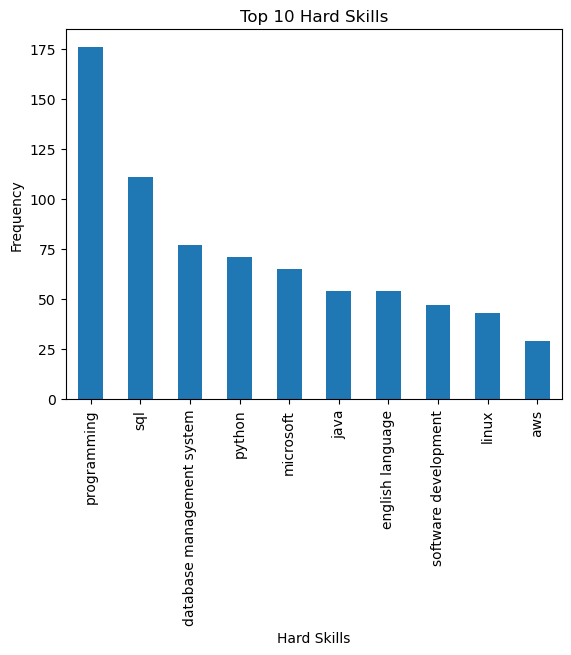

Cluster 11


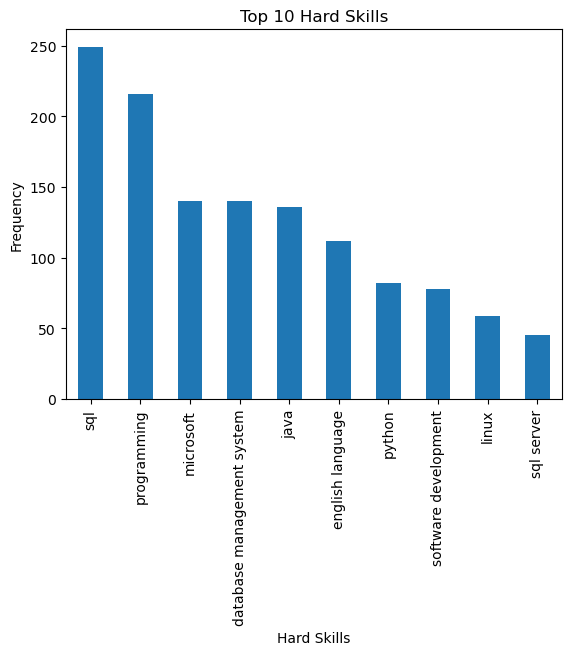

Cluster 9


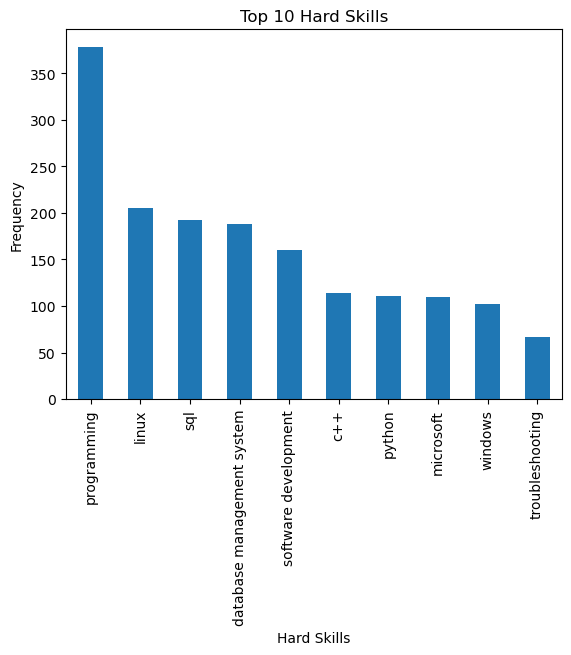

Cluster 7


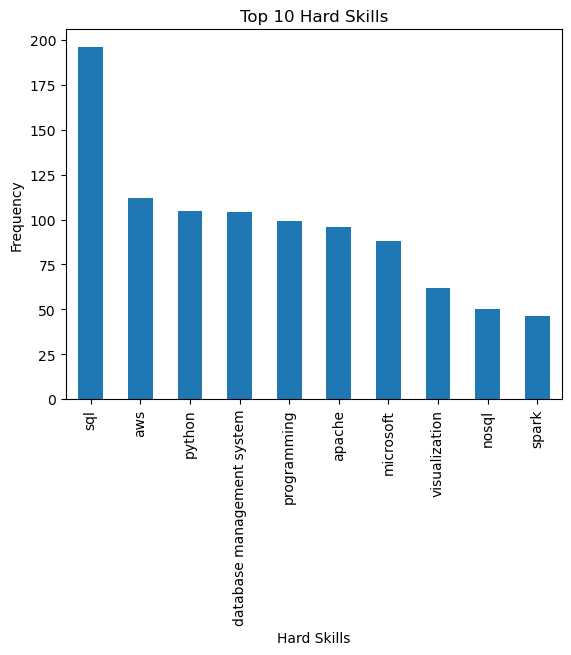

Cluster 10


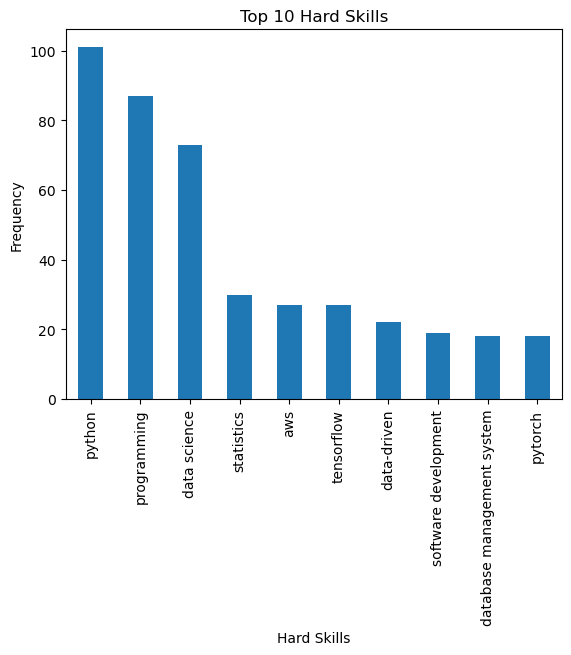

Cluster 0


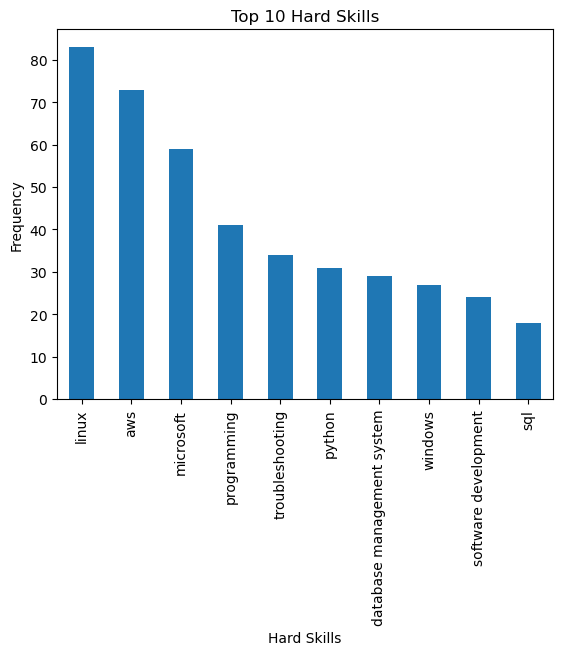

Cluster 3


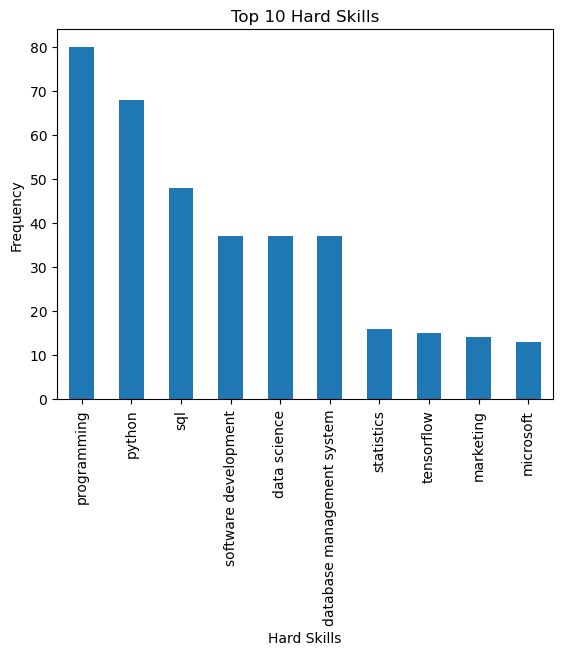

Cluster 6


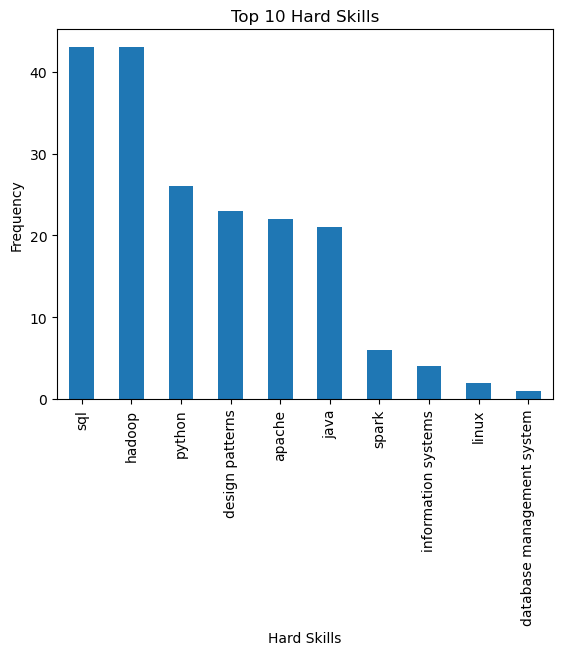

Cluster 8


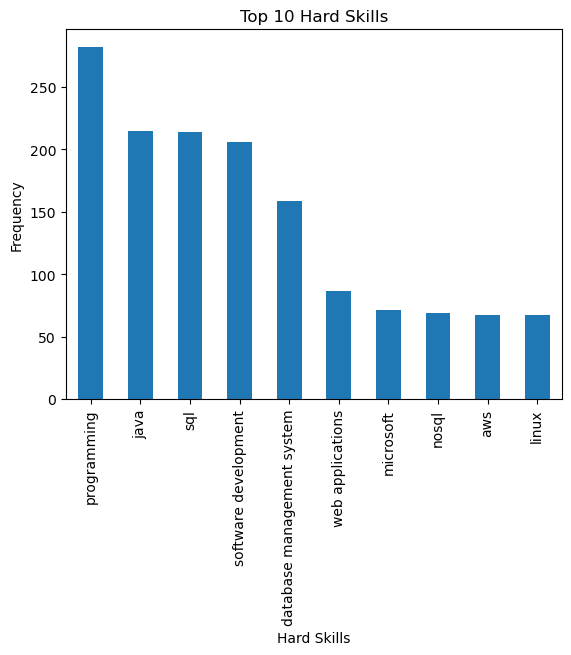

Cluster 2


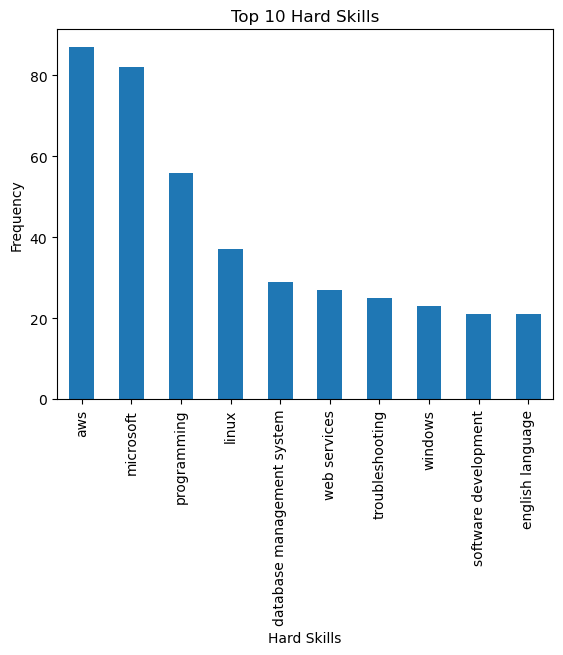

In [ ]:
for i in diz_hs_freq:
    print(f'Cluster {i}')
    diz_hs_freq[i][:10].plot(kind='bar')
    plt.title('Top 10 Hard Skills')
    plt.xlabel('Hard Skills')
    plt.ylabel('Frequency')
    plt.show()

### DV soft / hard skills

In [ ]:
df_ss_diz = {key: pd.DataFrame(value, columns=['soft skills']) for key, value in diz_ss.items()}

In [ ]:
diz_ss_top10={}
for k,v in df_ss_diz.items():
    diz_ss_top10[k]=v.value_counts().head(10)

In [ ]:
labels_ss=[]
softskills=[]
frequenza_ss=[]

In [ ]:
for k,v in diz_ss_top10.items():
    for ss, freq in v.items():
        labels_ss.append(k)
        softskills.append(ss)
        frequenza_ss.append(freq)

In [ ]:
df_ss_top10=pd.DataFrame({"label": labels_ss, "Soft Skills": softskills, "frequenza": frequenza_ss})

In [ ]:
df_ss_top10['Soft Skills']=df_ss_top10['Soft Skills'].astype(str)

In [ ]:
df_ss_top10['Soft Skills']=df_ss_top10['Soft Skills'].str.replace(r'[\(\),\'"]', '', regex=True).str.strip()

In [ ]:
for i in df_ss_top10['label'].unique():
    freq_tot_ss=df_ss_top10.loc[df_ss_top10['label']==i]['frequenza'].sum()
    for index,row in df_ss_top10.iterrows():
        if row['label']==i:
            df_ss_top10.at[index,'freq_rel']=round(row['frequenza']/freq_tot_ss, 4)

In [ ]:
# soft skills visualization

input_dropdown = alt.binding_select(options=sorted(df_ss_top10['label'].unique()), name='Cluster ')
selection = alt.selection_point(fields=['label'], bind=input_dropdown)
color = alt.condition(
    selection,
    alt.Color('Origin:N').legend(None),
    alt.value('lightgray')
)


alt.Chart(df_ss_top10).mark_bar(tooltip=True).encode(
        alt.Y('Soft Skills:N',sort=alt.SortField(field='freq_rel', order='descending'), title=None, axis=alt.Axis(labelAngle=0)),
        alt.X('freq_rel:Q', title='Frequency', scale=alt.Scale(domain=[0, 0.5])),
        #alt.Color('Job title:N', scale=alt.Scale(scheme='category20')),
        color=color,
        tooltip=[alt.Tooltip('Soft Skills:N', title='Soft Skills'), alt.Tooltip('freq_rel:Q', title='Percentage', format='.2%')]
).properties(title='Soft skills analysis').transform_filter(selection).add_params(selection).display()

alt.Chart(...)

In [ ]:
df_hs_diz = {key: pd.DataFrame(value, columns=['hard skills']) for key, value in diz_hs.items()}

In [ ]:
diz_hs_top10={}
for k,v in df_hs_diz.items():
    diz_hs_top10[k]=v.value_counts().head(10)

In [ ]:
labels_hs=[]
hardskills=[]
frequenza_hs=[]

In [ ]:
for k,v in diz_hs_top10.items():
    for hs, freq in v.items():
        labels_hs.append(k)
        hardskills.append(hs)
        frequenza_hs.append(freq)

In [ ]:
df_hs_top10=pd.DataFrame({"label": labels_hs, "Hard skills": hardskills, "frequenza": frequenza_hs})

In [ ]:
df_hs_top10['Hard skills']=df_hs_top10['Hard skills'].astype(str)

In [ ]:
df_hs_top10['Hard skills']=df_hs_top10['Hard skills'].str.replace(r'[\(\),\'"]', '', regex=True).str.strip()

In [ ]:
for i in df_hs_top10['label'].unique():
    freq_tot_hs=df_hs_top10.loc[df_hs_top10['label']==i]['frequenza'].sum()
    for index,row in df_hs_top10.iterrows():
        if row['label']==i:
            df_hs_top10.at[index,'freq_rel']=round(row['frequenza']/freq_tot_hs, 4)

In [ ]:
# visualizzazione hard skills con menù a tendina

input_dropdown = alt.binding_select(options=sorted(df_hs_top10['label'].unique()), name='Cluster ')
selection = alt.selection_point(fields=['label'], bind=input_dropdown)
color = alt.condition(
    selection,
    alt.Color('Origin:N').legend(None),
    alt.value('lightgray')
)

alt.Chart(df_hs_top10).mark_bar(tooltip=True).encode(
        alt.Y('Hard skills:N',title=None, axis=alt.Axis(labelAngle=0), sort=alt.SortField(field='freq_rel', order='descending')),
        alt.X('freq_rel:Q', title='Frequency', scale=alt.Scale(domain=[0, 0.5]) ),
        #alt.Color('Job title:N', scale=alt.Scale(scheme='category20')),
        color=color,
        tooltip=[alt.Tooltip('Hard skills:N', title='Hard skills'), alt.Tooltip('freq_rel:Q', title='Percentage', format='.2%')]
).properties(title='Hard skills analysis').transform_filter(selection).add_params(selection).display()

alt.Chart(...)

### DV: LINKEDIN + SOFT + HARD

In [ ]:
input_dropdown = alt.binding_select(options=sorted(df_ss_top10['label'].unique()), name='Cluster ')
selection = alt.selection_point(fields=['label'], bind=input_dropdown, value=[{'label':min(df_ss_top10.label)}])

for i in sorted(df_ss_top10['label'].unique()):

    color_ls = alt.condition(
        selection,
        alt.Color('label:N').legend(None),
        alt.value('lightgray')
    )

    # LinkedIn skills
    chart_LinkedIn_skills = alt.Chart(df_value_counts).mark_bar(size=10, tooltip=True).encode(
        alt.Y('LinkedIn Skills List:N', title=None, axis=alt.Axis(labelAngle=0), sort=alt.SortField(field='freq_rel', order='descending')),
        alt.X('freq_rel:Q', title=None, scale=alt.Scale(domain=[0, 0.5])),
        color=color_ls,
        tooltip=[alt.Tooltip('LinkedIn Skills List:N', title='LinkedIn Skills List'), alt.Tooltip('freq_rel:Q', title='Percentage', format='.2%')]
    ).transform_filter(selection).add_params(selection).properties(height=120, title='LinkedIn Skills distribution')

    color_ss = alt.condition(
        selection,
        alt.Color('label:N').legend(None),
        alt.value('lightgray')
    )

    # soft skills
    chart_soft_skills = alt.Chart(df_ss_top10).mark_bar(size=10, tooltip=True).encode(
        alt.Y('Soft Skills:N', sort=alt.SortField(field='freq_rel', order='descending'), title=None, axis=alt.Axis(labelAngle=0)),
        alt.X('freq_rel:Q',title=None, scale=alt.Scale(domain=[0, 0.5])),
        color=color_ss,
        tooltip=[alt.Tooltip('Soft Skills:N', title='Soft Skills'), alt.Tooltip('freq_rel:Q', title='Percentage', format='.2%')]
    ).transform_filter(selection).add_params(selection).properties(height=120, title='Soft Skills distribution')

    color_hs = alt.condition(
        selection,
        alt.Color('label:N').legend(None),
        alt.value('lightgray')
    )

    # hard skills
    chart_hard_skills = alt.Chart(df_hs_top10).mark_bar(size=10, tooltip=True).encode(
        alt.Y('Hard skills:N', title=None, axis=alt.Axis(labelAngle=0), sort=alt.SortField(field='freq_rel', order='descending')),
        alt.X('freq_rel:Q',title=None, scale=alt.Scale(domain=[0, 0.5])),
        color=color_hs,
        tooltip=[alt.Tooltip('Hard skills:N', title='Hard skills'), alt.Tooltip('freq_rel:Q', title='Percentage', format='.2%')]
    ).transform_filter(selection).add_params(selection).properties(height=120, title='Hard Skills distribution')

    # Combina i tre grafici uno accanto all'altro
    combined_chart = alt.vconcat(chart_LinkedIn_skills, chart_soft_skills, chart_hard_skills).resolve_scale(color='independent')

    # Visualizza il grafico combinato
combined_chart.display()

alt.VConcatChart(...)

In [ ]:
chart_json = combined_chart.to_json()
with open(fr'C:\Users\simon\Desktop\combined_chart_Skills_Nuovo.json', 'w') as f:
    f.write(chart_json)

# SENTIMENT ANALYSIS

In [ ]:
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()

In [ ]:
def sentiment(cella):
    v=vader.polarity_scores(cella)
    return v

df['sentiment_analysis']=df['description_eng'].apply(sentiment)

In [ ]:
df['sentiment_analysis'][285]

In [ ]:
positive_sentiment={}
negative_sentiment={}
neutral_sentiment={}
for index, i in enumerate(df['sentiment_analysis']):
    if i['compound']>=0.6:
        positive_sentiment[index]=i['compound']
    if -0.6<i['compound']<0.6:
        neutral_sentiment[index]=i['compound']
    if i['compound']<=-0.6:
        negative_sentiment[index]=i['compound']

In [ ]:
len(positive_sentiment), len(negative_sentiment), len(neutral_sentiment)

In [ ]:
negative_sentiment

In [ ]:
df['description_eng'][253]

# DF PULITO

In [ ]:
df.to_csv(r'C:\Users\simon\Desktop\df_Pulito_Tot.csv', index=False)

NameError: name 'df' is not defined